In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import glob
import os
import re
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
from sklearn.preprocessing import LabelEncoder


In [3]:
# Define the directories containing images and shapefiles
walrus_dir = os.path.abspath("../../")
#"C:\\Users\\Student\\Documents\\101_walrus_data

# Define the directories containing images and shapefiles
image_dir = os.path.join(walrus_dir, "data", "train", "clipped_images")
shapefile_dir = os.path.join(walrus_dir, "data", "train", "clipped_train")
unlabeled_image_dir = os.path.join(walrus_dir, "data", "train", "clipped_unlabeled")
new_walrus_dir = os.path.join(walrus_dir, "data", "train", "walrus_shapefiles")

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(all_image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in all_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(all_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

In [4]:
print("Total images:", len(all_image_paths))
print("Images paired with shapefiles:", len(file_pairs))
print("Images with general shapefiles:", sum(1 for _, (gen, _) in file_pairs.items() if gen is not None))
print("Images with walrus shapefiles:", sum(1 for _, (_, wal) in file_pairs.items() if wal is not None))

for island in set(extract_island_and_date(os.path.basename(img))[0] for img in all_image_paths):
    island_pairs = {img: shp for img, shp in file_pairs.items() if extract_island_and_date(os.path.basename(img))[0] == island}
    print(f"\n{island}:")
    print(f"  Total images: {sum(1 for img in all_image_paths if extract_island_and_date(os.path.basename(img))[0] == island)}")
    print(f"  Paired images: {len(island_pairs)}")
    print(f"  With general shapefiles: {sum(1 for _, (gen, _) in island_pairs.items() if gen is not None)}")
    print(f"  With walrus shapefiles: {sum(1 for _, (_, wal) in island_pairs.items() if wal is not None)}")

Total images: 30
Images paired with shapefiles: 20
Images with general shapefiles: 14
Images with walrus shapefiles: 10

buch:
  Total images: 6
  Paired images: 6
  With general shapefiles: 4
  With walrus shapefiles: 3

moff:
  Total images: 1
  Paired images: 1
  With general shapefiles: 1
  With walrus shapefiles: 0

tor:
  Total images: 9
  Paired images: 8
  With general shapefiles: 4
  With walrus shapefiles: 5

pal:
  Total images: 8
  Paired images: 3
  With general shapefiles: 3
  With walrus shapefiles: 0

pool:
  Total images: 1
  Paired images: 0
  With general shapefiles: 0
  With walrus shapefiles: 0

sars:
  Total images: 5
  Paired images: 2
  With general shapefiles: 2
  With walrus shapefiles: 2


In [8]:
# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Step 3: Plot spectral signatures for all classes across all islands
# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  
    'Blue': (465, 515), 
    'Green 1': (513, 549), 
    'Green': (547, 583),  
    'Yellow': (600, 620),  
    'Red': (630, 680), 
    'Red Edge': (697, 713),  
    'NIR': (845, 885)   
}

In [9]:
# Step 2: Compute total number of pixels in each class
class_counts = dataset['labels'].value_counts()
print("Total number of pixels in each class:")
print(class_counts)

Total number of pixels in each class:
labels
ocean           779288
ice             300231
rock             92856
freshwater       40251
walrus_mixed      1309
walrus_pure        222
Name: count, dtype: int64


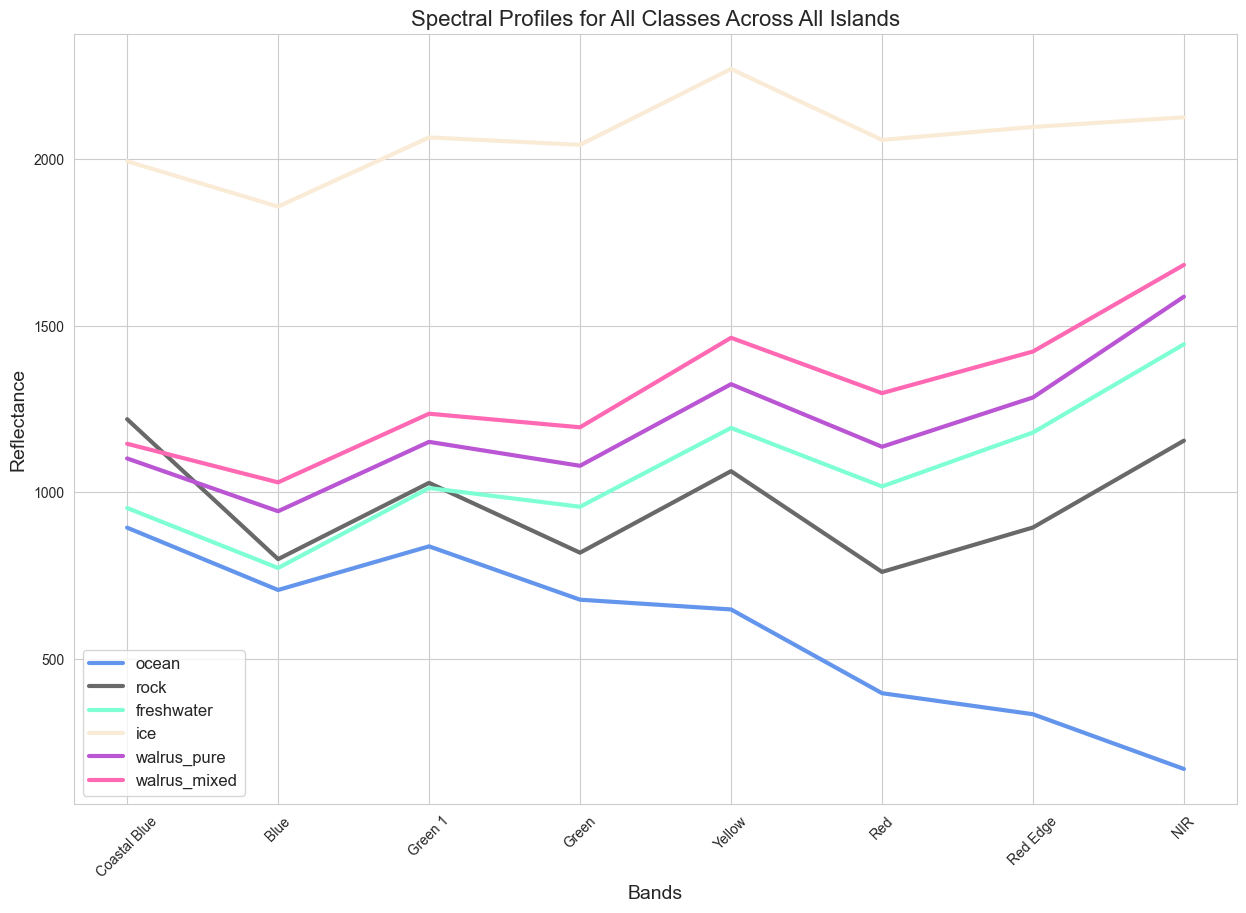

In [10]:
unique_labels = dataset['labels'].unique()
bands = np.arange(features.shape[1])
mean_profiles = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))

mean_profiles = np.array(mean_profiles)

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    plt.plot(bands, mean, label=class_label, color=label_colors.get(class_label, 'black'), linewidth=3)  # Thicker line
    
# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands', fontsize=16)
plt.legend(fontsize=12)
plt.show()    

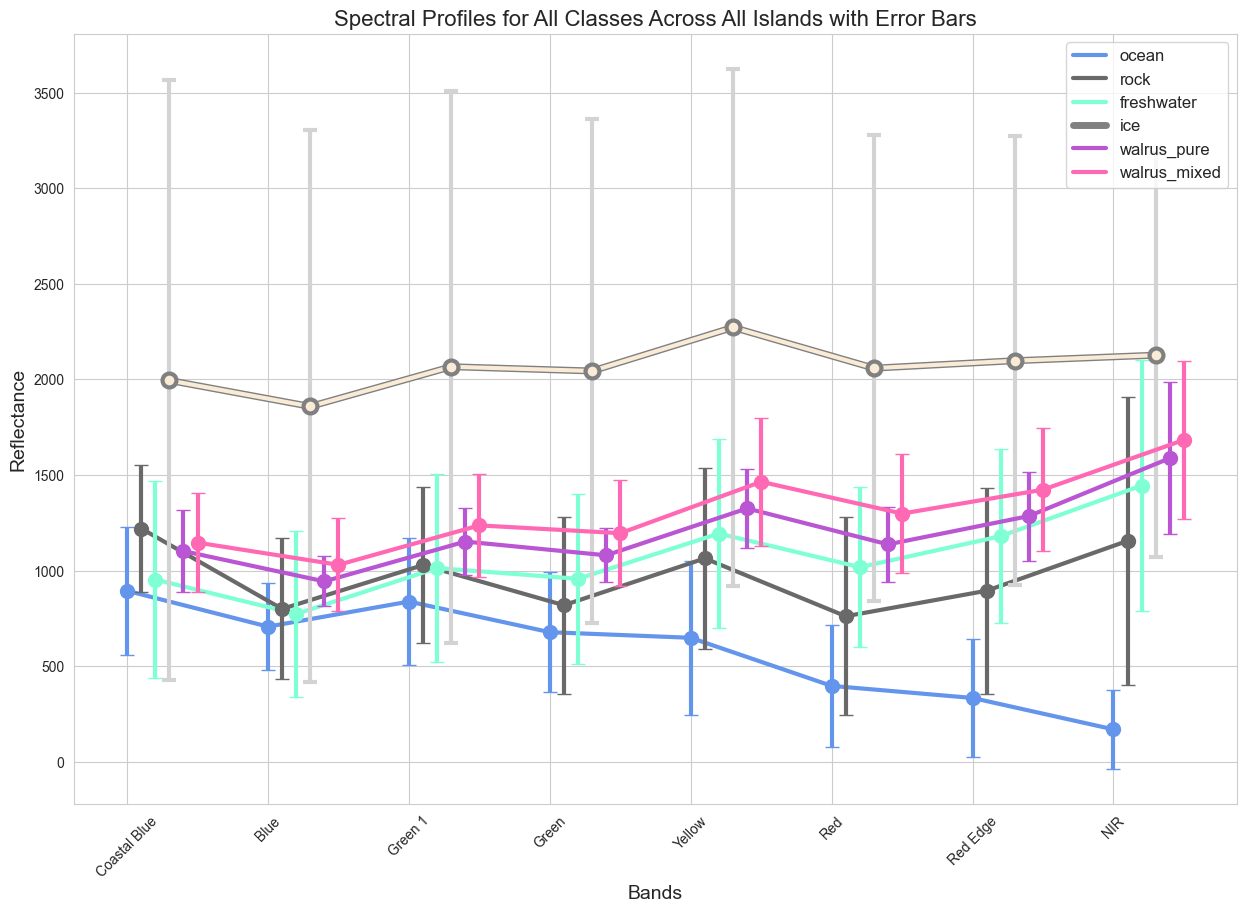

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  # Coastal Blue
    'Blue': (465, 515),  # Blue
    'Green 1': (513, 549),  # Green 1
    'Green': (547, 583),  # Green
    'Yellow': (600, 620),  # Yellow
    'Red': (630, 680),  # Red
    'Red Edge': (697, 713),  # Red Edge
    'NIR': (845, 885)   # NIR
}

# Assuming the dataset is already loaded
unique_labels = dataset['labels'].unique()
bands = np.arange(8)
mean_profiles = []
std_profiles = []

# Calculate mean and std profiles for each class
for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

staggering_factor = 0.1

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    offset = class_index * staggering_factor
    color = label_colors.get(class_label, 'black')
    
    # Plot mean line with grey outline for 'ice' class
    if class_label == 'ice':
        plt.plot(bands + offset, mean, label=class_label, color='grey', linewidth=5)
        plt.plot(bands + offset, mean, color=color, linewidth=3)
        plt.errorbar(bands + offset, mean, yerr=std, color=color, fmt='o', capsize=5, markersize=10, ecolor='lightgrey', elinewidth=3, markeredgewidth=3, markeredgecolor='grey')
    else:
        plt.plot(bands + offset, mean, label=class_label, color=color, linewidth=3)
        plt.errorbar(bands + offset, mean, yerr=std, color=color, fmt='o', capsize=5, markersize=10, elinewidth=3)

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands with Error Bars', fontsize=16)
plt.legend(fontsize=12)
plt.show()


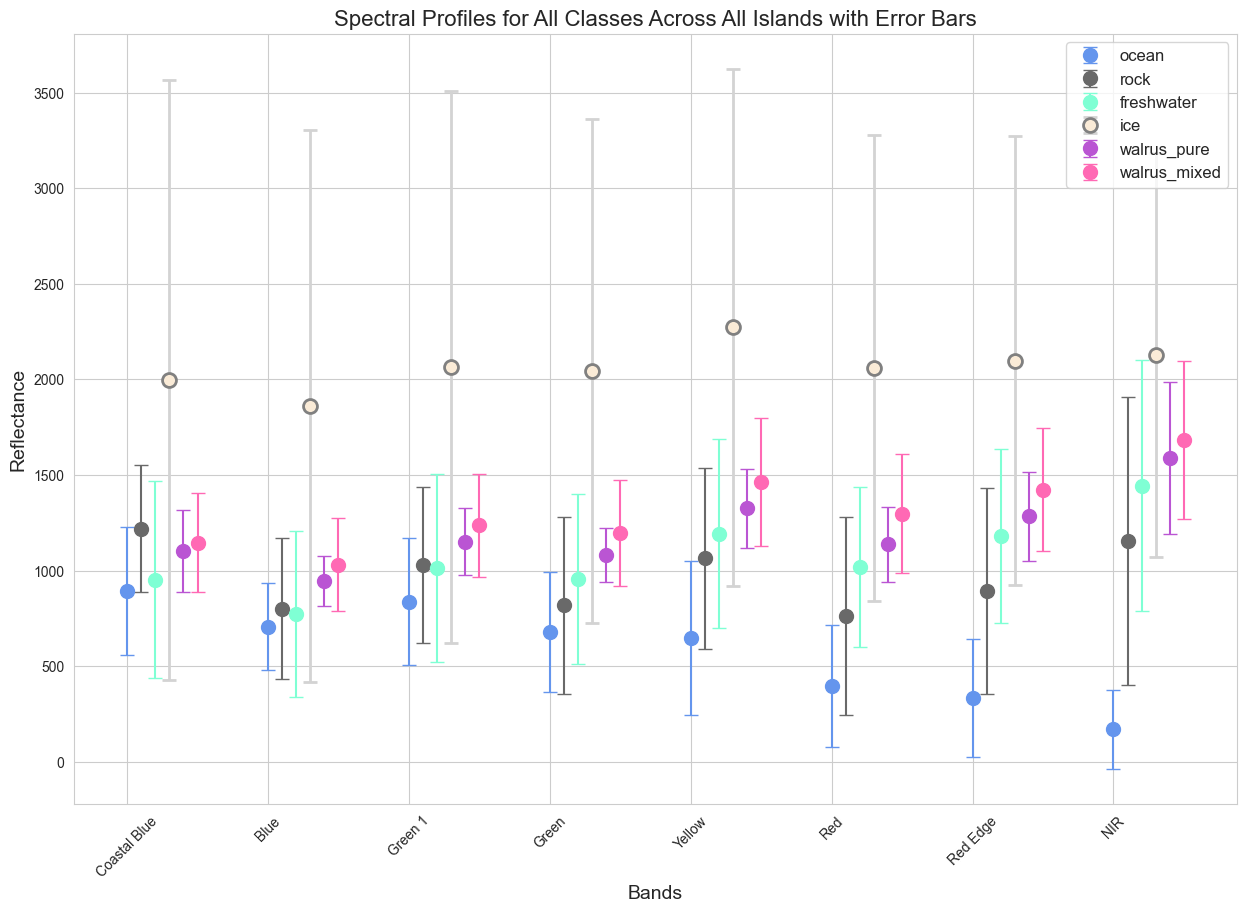

In [12]:
# Step 4: Plot spectral signatures with error bars for all classes across all islands
mean_profiles = []
std_profiles = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

staggering_factor = 0.1

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    offset = class_index * staggering_factor
    if class_label == 'ice':
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color='antiquewhite', fmt='o', capsize=5, markersize=10, ecolor='lightgrey', elinewidth=2, markeredgewidth=2, markeredgecolor='grey')
    else:
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color=label_colors.get(class_label, 'black'), fmt='o', capsize=5, markersize=10)

plt.xticks(ticks=bands, labels=band_names, rotation=45)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands with Error Bars', fontsize=16)
plt.legend(fontsize=12)
plt.show()

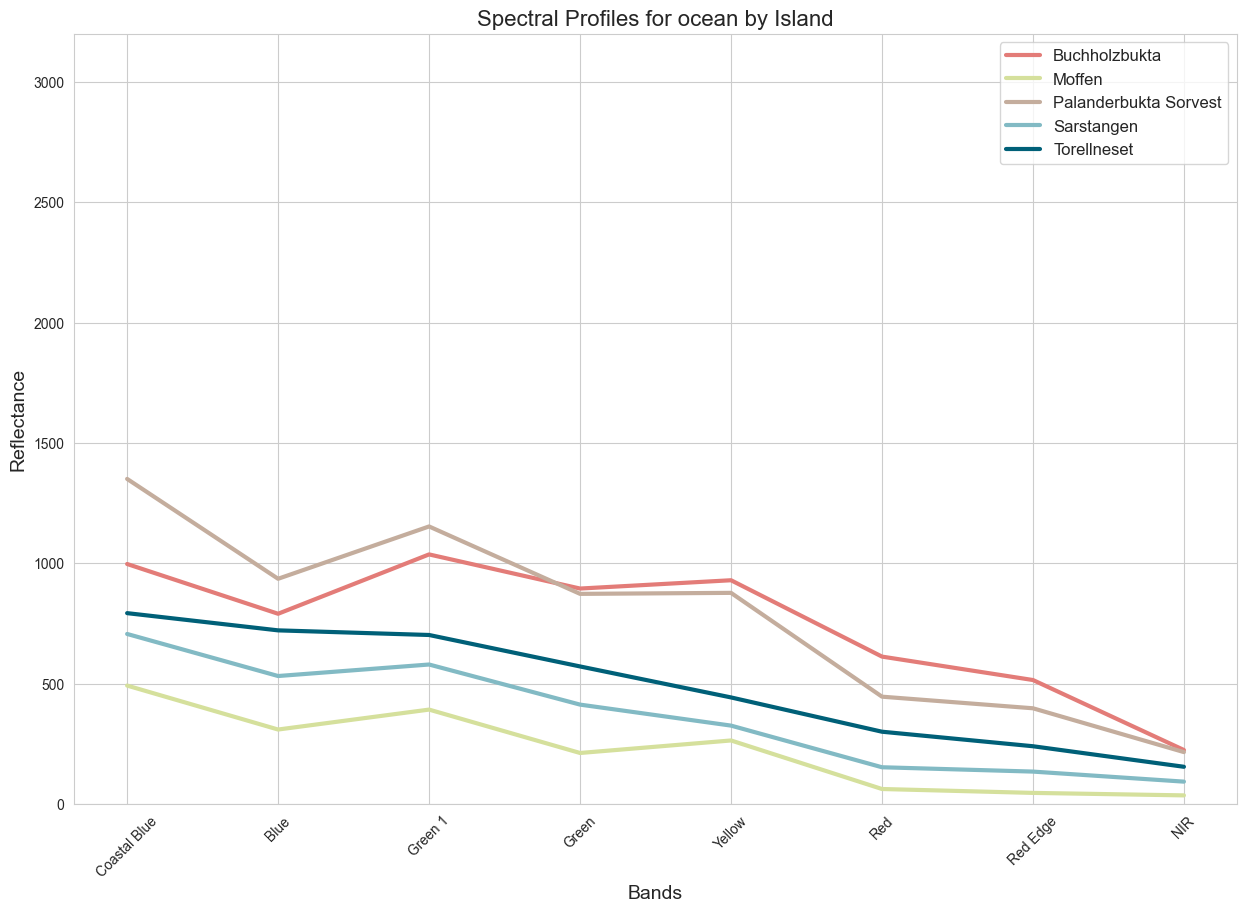

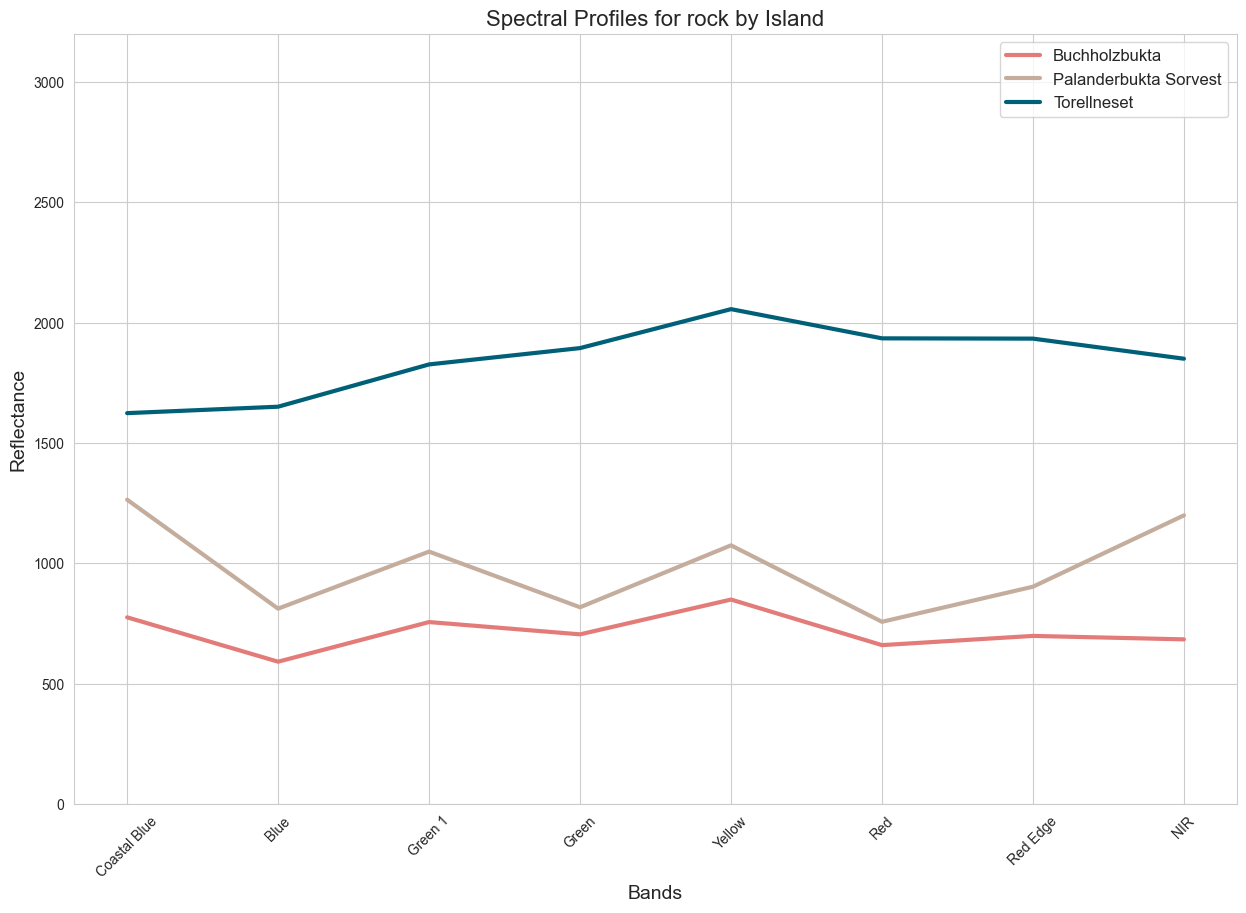

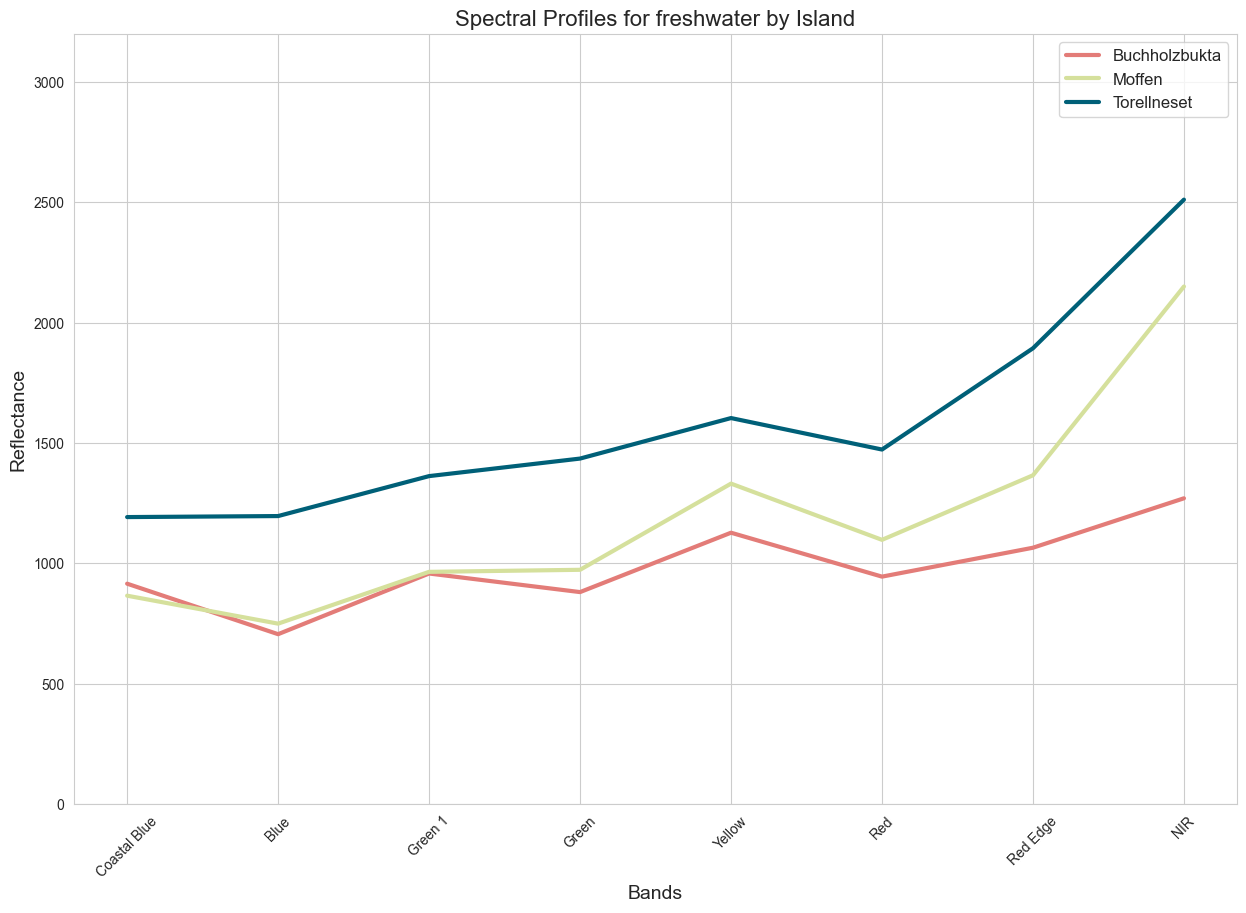

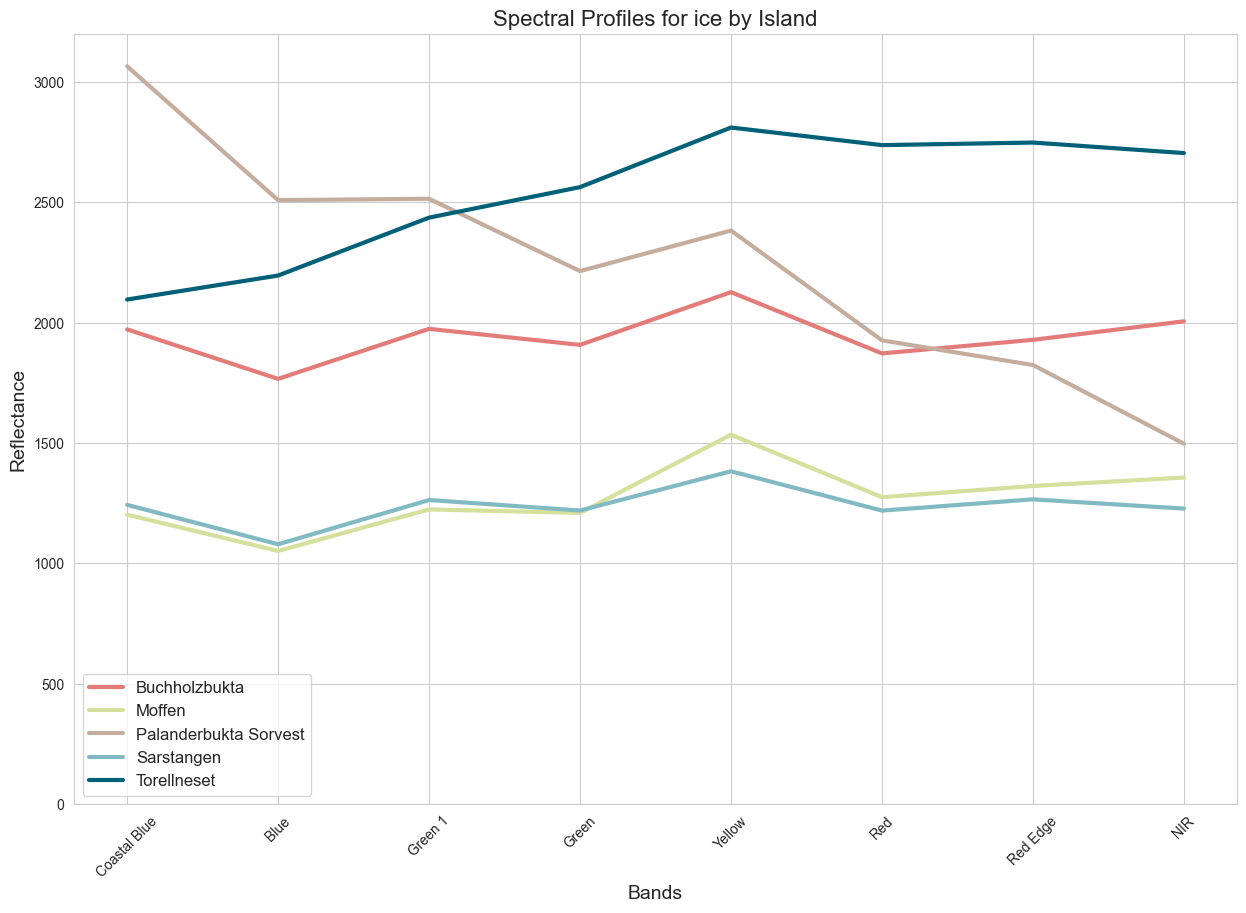

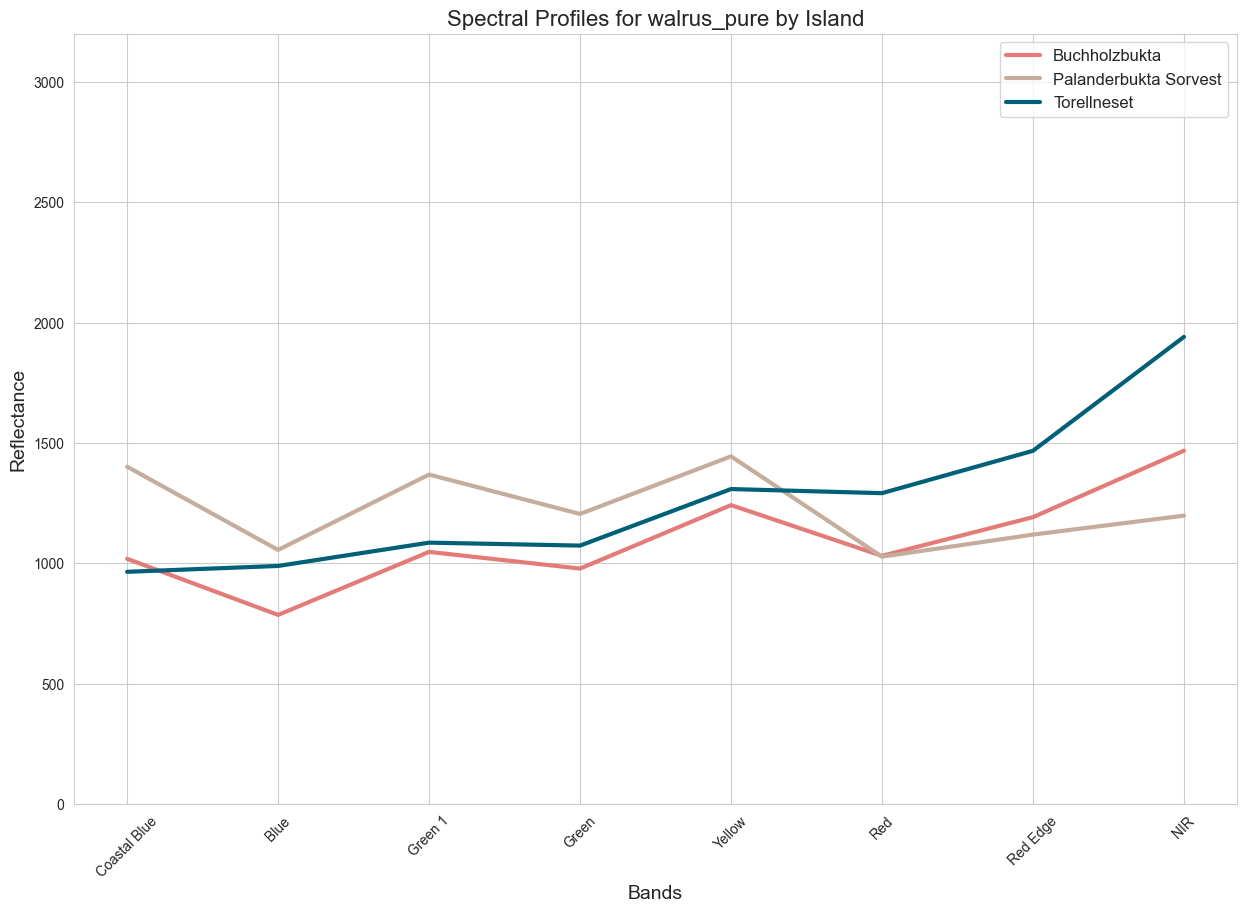

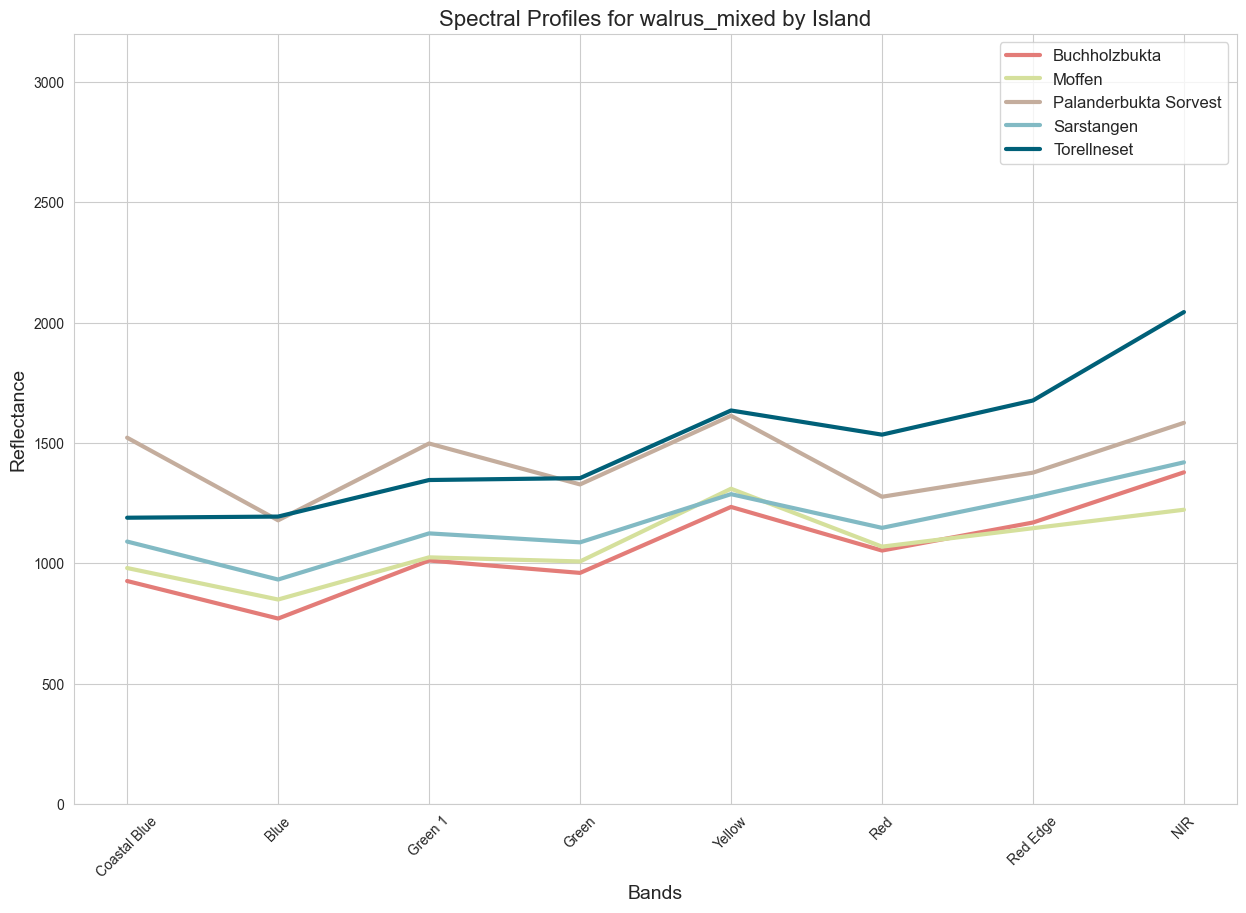

In [13]:
# Extract the islands from the dataset
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

# Define color palette similar to the provided image
island_colors = {
    'buch': '#E37C78',  # Buchholzbukta
    'moff': '#D5E09C',  # Moffen
    'pal': '#C4AD9D',  # Palanderbukta Sorvest
    'sars': '#82BAC4',  # Sarstangen
    'tor': '#006078'   # Torellneset
}

# Define a mapping from island identifiers to descriptive names
island_names = {
    'buch': 'Buchholzbukta',
    'moff': 'Moffen',
    'pal': 'Palanderbukta Sorvest',
    'sars': 'Sarstangen',
    'tor': 'Torellneset'
}

for class_label in unique_labels:
    plt.figure(figsize=(15, 10))
    for i, island in enumerate(islands):
        island_class_data = dataset[(dataset['labels'] == class_label) & (dataset['image_name'].str.contains(island))].iloc[:, :8].values
        if island_class_data.shape[0] > 0:
            mean = island_class_data.mean(axis=0)
            plt.plot(bands, mean, label=island_names[island], color=list(island_colors.values())[i], linewidth=3)

    plt.ylim(0, 3200)
    plt.xticks(ticks=bands, labels=band_names, rotation=45)
    plt.xlabel('Bands', fontsize=14)
    plt.ylabel('Reflectance', fontsize=14)
    plt.title(f'Spectral Profiles for {class_label} by Island', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()

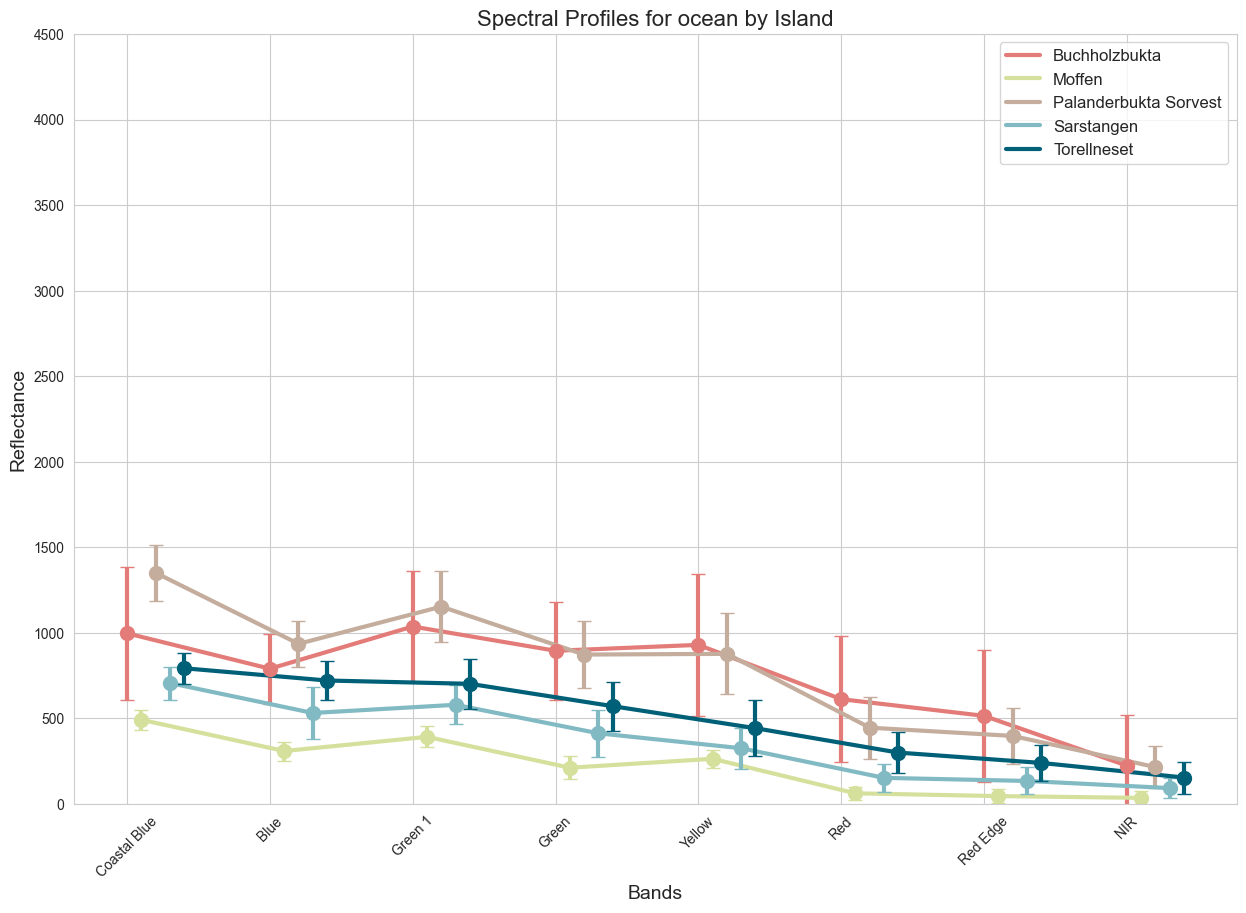

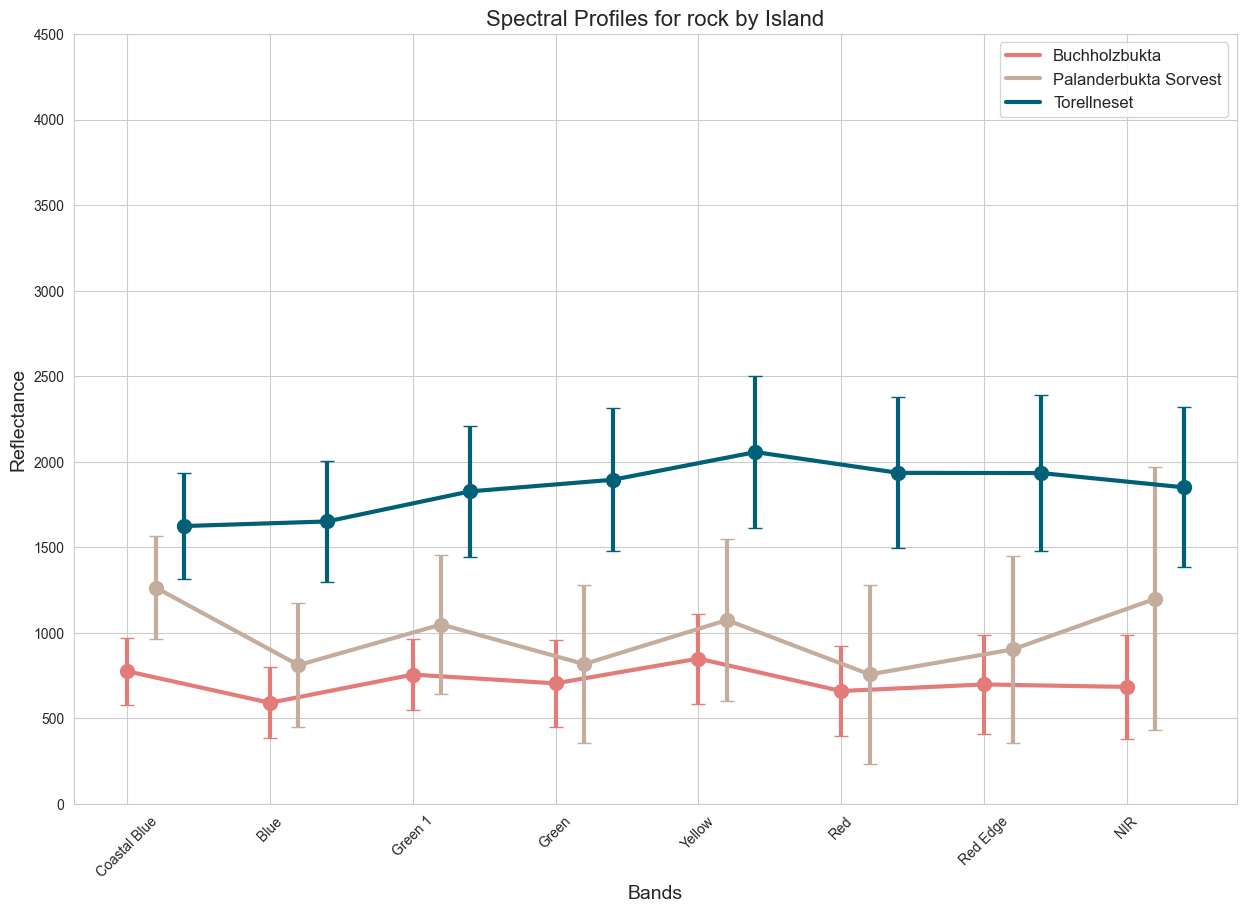

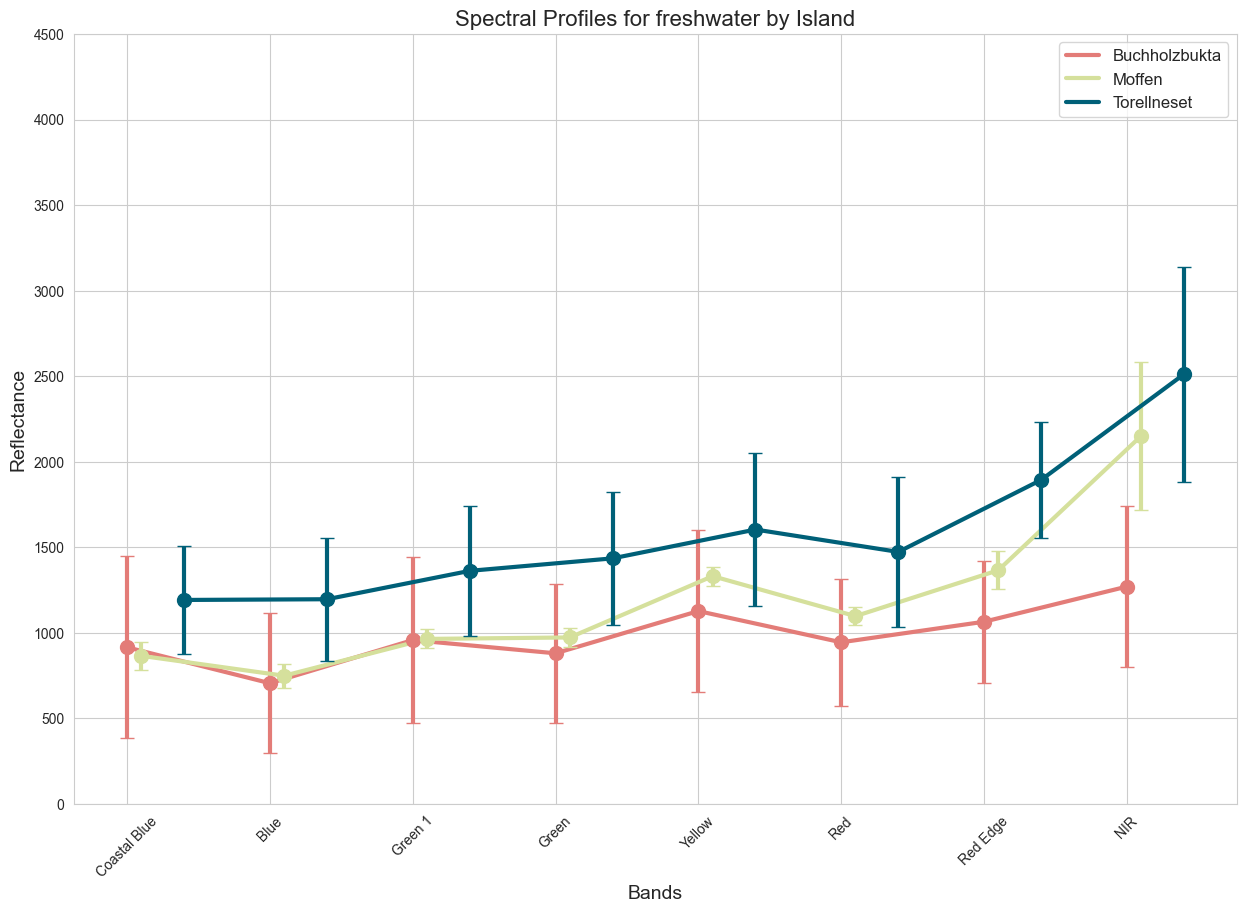

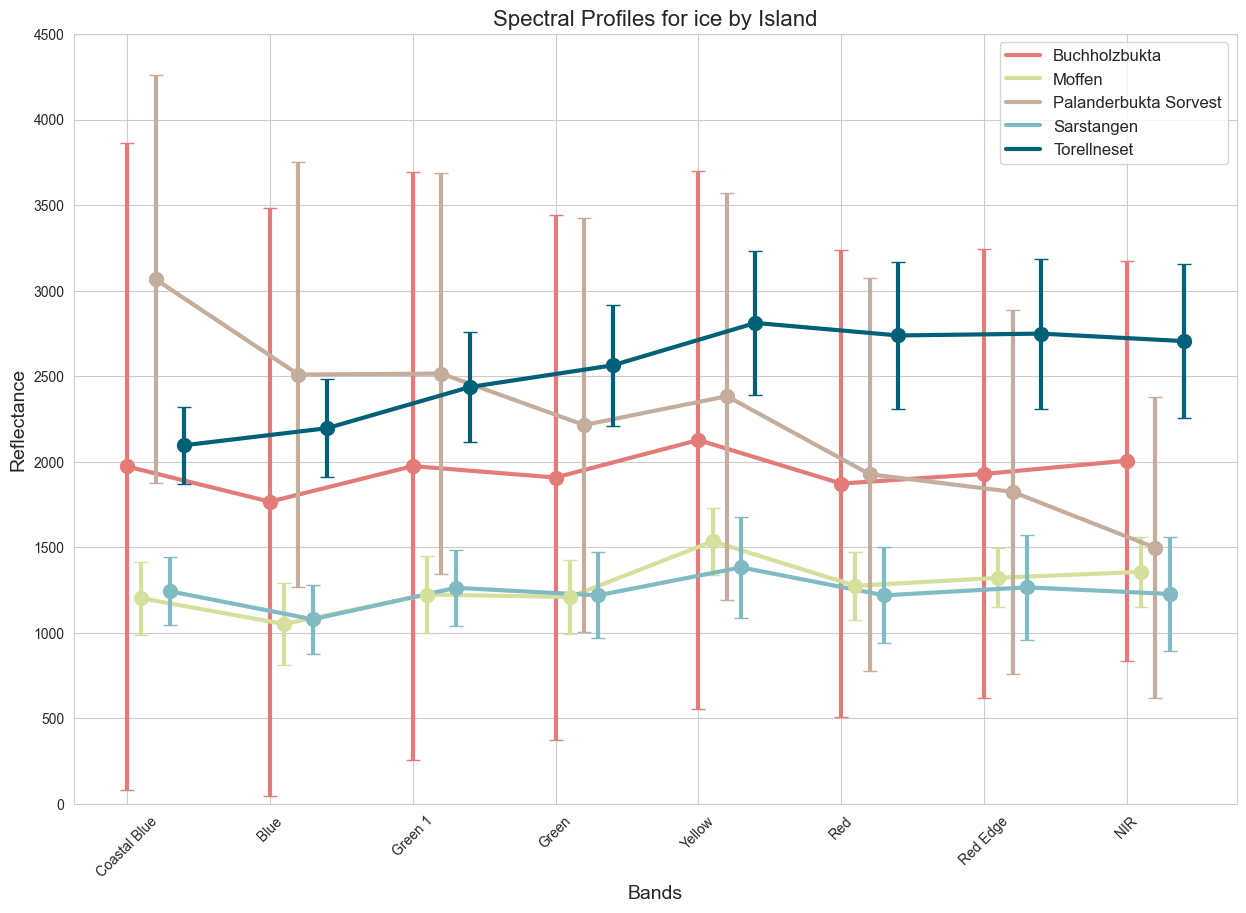

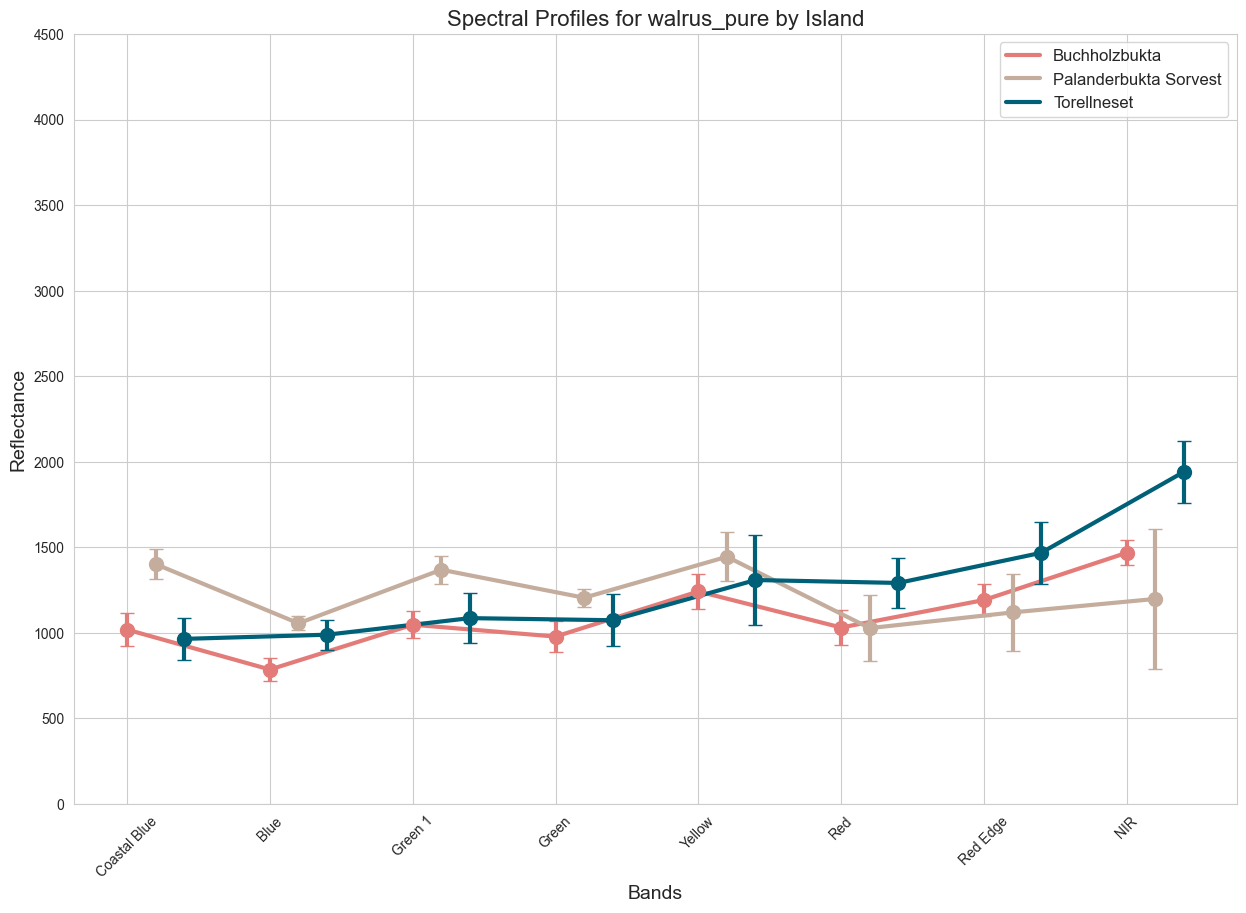

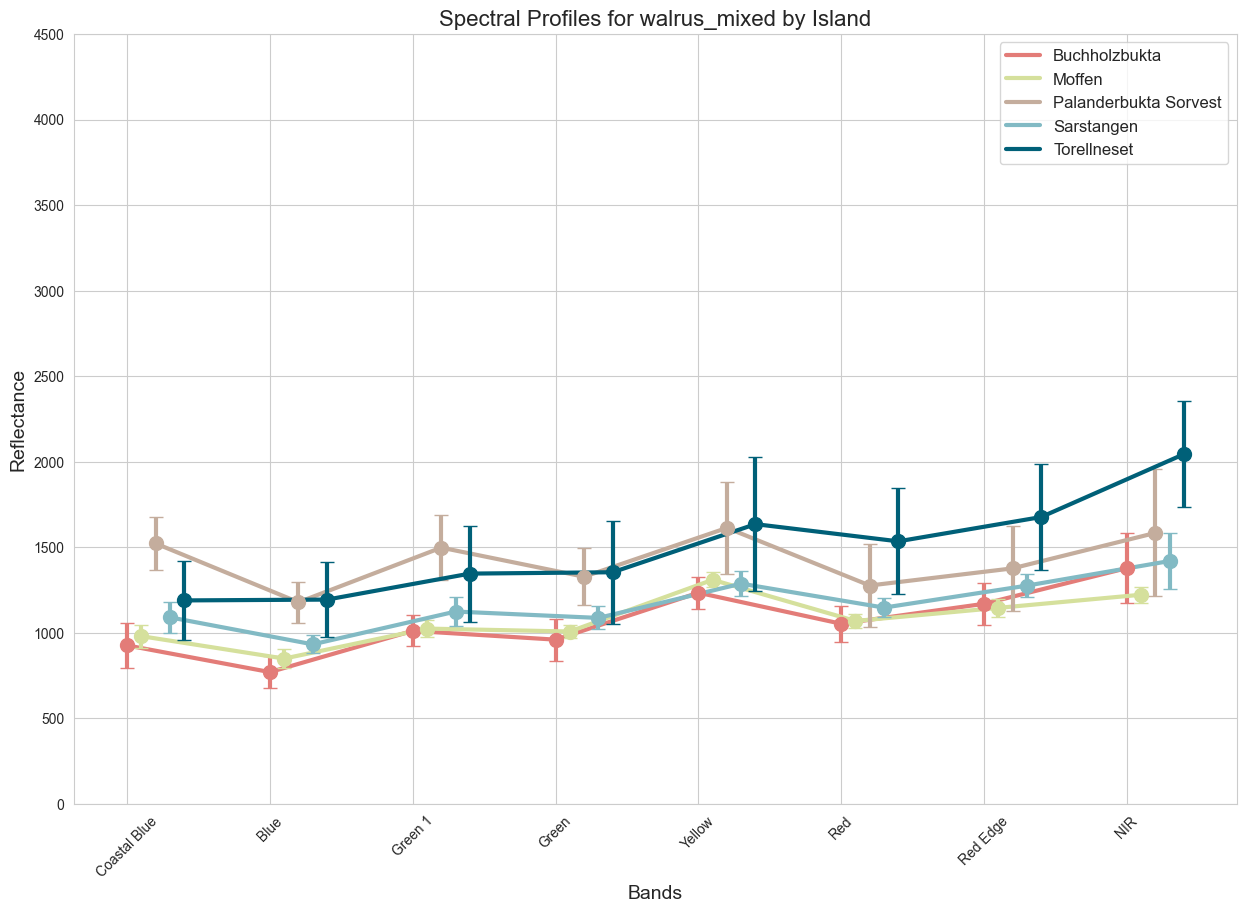

In [16]:
# Extract the islands from the dataset
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

# Define color palette similar to the provided image
island_colors = {
    'buch': '#E37C78',  # Buchholzbukta
    'moff': '#D5E09C',  # Moffen
    'pal': '#C4AD9D',  # Palanderbukta Sorvest
    'sars': '#82BAC4',  # Sarstangen
    'tor': '#006078'   # Torellneset
}

# Define a mapping from island identifiers to descriptive names
island_names = {
    'buch': 'Buchholzbukta',
    'moff': 'Moffen',
    'pal': 'Palanderbukta Sorvest',
    'sars': 'Sarstangen',
    'tor': 'Torellneset'
}

# Define the staggering factor
staggering_factor = 0.1

for class_label in unique_labels:
    plt.figure(figsize=(15, 10))
    for i, island in enumerate(islands):
        island_class_data = dataset[(dataset['labels'] == class_label) & (dataset['image_name'].str.contains(island))].iloc[:, :8].values
        if island_class_data.shape[0] > 0:
            mean = island_class_data.mean(axis=0)
            std = island_class_data.std(axis=0)
            offset = i * staggering_factor
            plt.plot(bands + offset, mean, label=island_names[island], color=list(island_colors.values())[i], linewidth=3)
            plt.errorbar(bands + offset, mean, yerr=std, color=list(island_colors.values())[i], fmt='o', capsize=5, elinewidth=3, markersize=10)

    plt.ylim(0, 4500)
    plt.xticks(ticks=bands, labels=band_names, rotation=45)
    plt.xlabel('Bands', fontsize=14)
    plt.ylabel('Reflectance', fontsize=14)
    plt.title(f'Spectral Profiles for {class_label} by Island', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()


In [1]:

# Define the staggering factor
staggering_factor = 0.1

for class_label in unique_labels:
    plt.figure(figsize=(15, 10))
    for i, island in enumerate(islands):
        island_class_data = dataset[(dataset['labels'] == class_label) & (dataset['image_name'].str.contains(island))].iloc[:, :8].values
        if island_class_data.shape[0] > 0:
            mean = island_class_data.mean(axis=0)
            std = island_class_data.std(axis=0)
            offset = i * staggering_factor
            plt.plot(bands + offset, mean, label=island_names[island], color=list(island_colors.values())[i], linewidth=3)
            plt.errorbar(bands + offset, mean, yerr=std, color=list(island_colors.values())[i], fmt='o', capsize=5, elinewidth=3, markersize=10)

    plt.ylim(0, 4200)
    plt.xticks(ticks=bands, labels=band_names, rotation=45)
    plt.xlabel('Bands', fontsize=14)
    plt.ylabel('Reflectance', fontsize=14)
    plt.title(f'Spectral Profiles for {class_label} by Island', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()

NameError: name 'unique_labels' is not defined

In [88]:
# Desired number of pixels for undersampling
desired_counts = {
    'walrus_mixed': 222,
    'walrus_pure': 222,
    'ocean': 222,
    'rock': 222,
    'freshwater': 222,
    'ice': 222
}

In [89]:
# Step 5: Undersample larger classes ensuring all islands are represented
undersampled_data = []

for label in unique_labels:
    island_class_data = dataset[dataset['labels'] == label]
    for island in islands:
        island_data = island_class_data[island_class_data['image_name'].str.contains(island)]
        if label in desired_counts:
            if len(island_data) > desired_counts[label] // len(islands):
                undersampled_data.append(resample(island_data, replace=False, n_samples=desired_counts[label] // len(islands)))
            else:
                undersampled_data.append(island_data)
        else:
            undersampled_data.append(island_data)

undersampled_dataset = pd.concat(undersampled_data)

new_class_counts = undersampled_dataset['labels'].value_counts()
print("New number of pixels after undersampling:")
print(new_class_counts)

# Print islands included in each class after undersampling
print("Islands included in each class after undersampling:")
for label in unique_labels:
    islands_in_class = undersampled_dataset[undersampled_dataset['labels'] == label]['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
    print(f"{label}: {', '.join(islands_in_class)}")

New number of pixels after undersampling:
labels
ocean           220
ice             220
walrus_mixed    220
rock            132
freshwater      132
walrus_pure     132
Name: count, dtype: int64
Islands included in each class after undersampling:
ocean: buch, moff, pal, sars, tor
rock: buch, pal, tor
freshwater: buch, moff, tor
ice: buch, moff, pal, sars, tor
walrus_pure: buch, pal, tor
walrus_mixed: buch, moff, pal, sars, tor


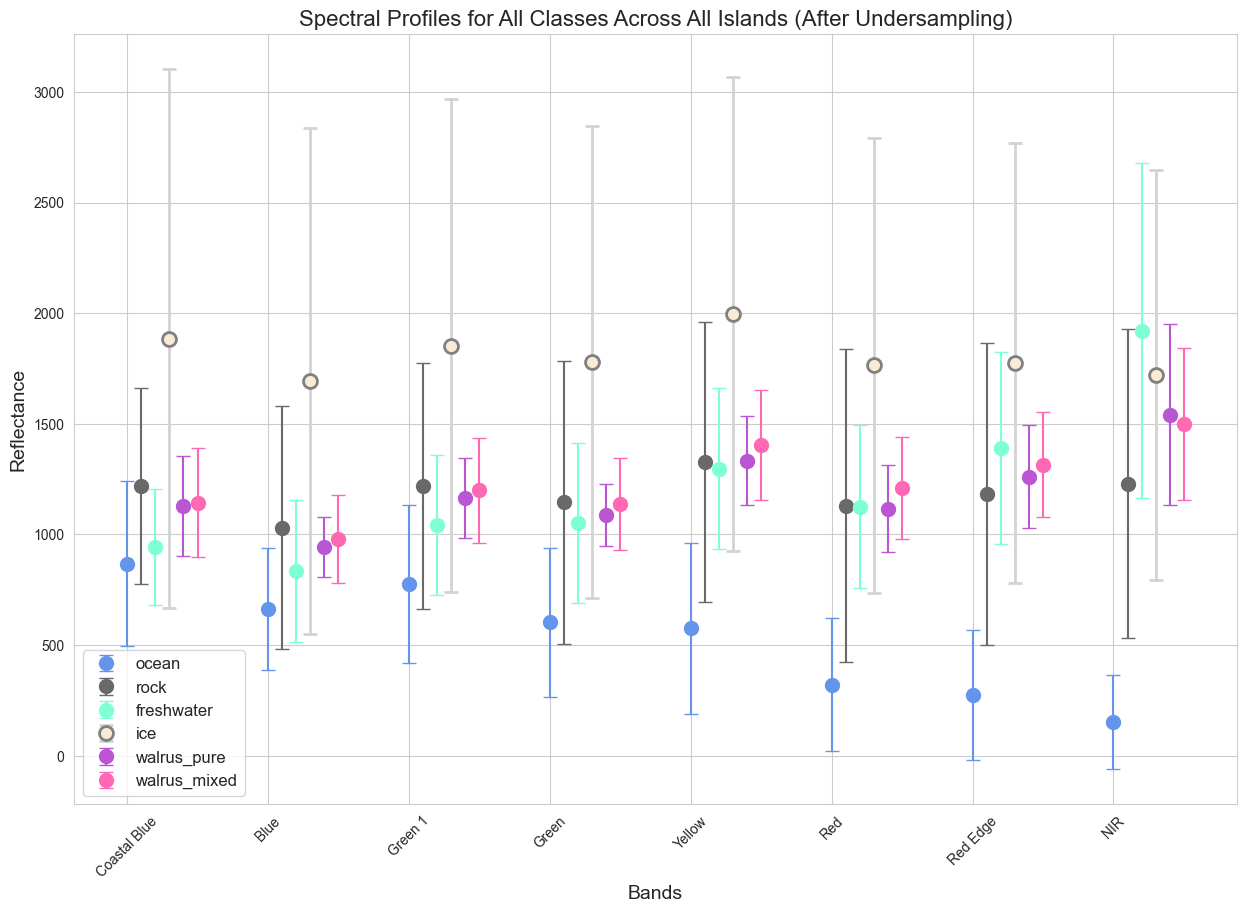

In [90]:
# Calculate mean and std profiles for undersampled data
undersampled_mean_profiles = []
undersampled_std_profiles = []

for label in unique_labels:
    class_data = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].values
    undersampled_mean_profiles.append(class_data.mean(axis=0))
    undersampled_std_profiles.append(class_data.std(axis=0))

undersampled_mean_profiles = np.array(undersampled_mean_profiles)
undersampled_std_profiles = np.array(undersampled_std_profiles)

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = undersampled_mean_profiles[class_index]
    std = undersampled_std_profiles[class_index]
    offset = class_index * staggering_factor
    if class_label == 'ice':
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color='antiquewhite', fmt='o', capsize=5, markersize=10, ecolor='lightgrey', elinewidth=2, markeredgewidth=2, markeredgecolor='grey')
    else:
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color=label_colors.get(class_label, 'black'), fmt='o', capsize=5, markersize=10)

plt.xticks(ticks=bands, labels=band_names, rotation=45)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands (After Undersampling)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

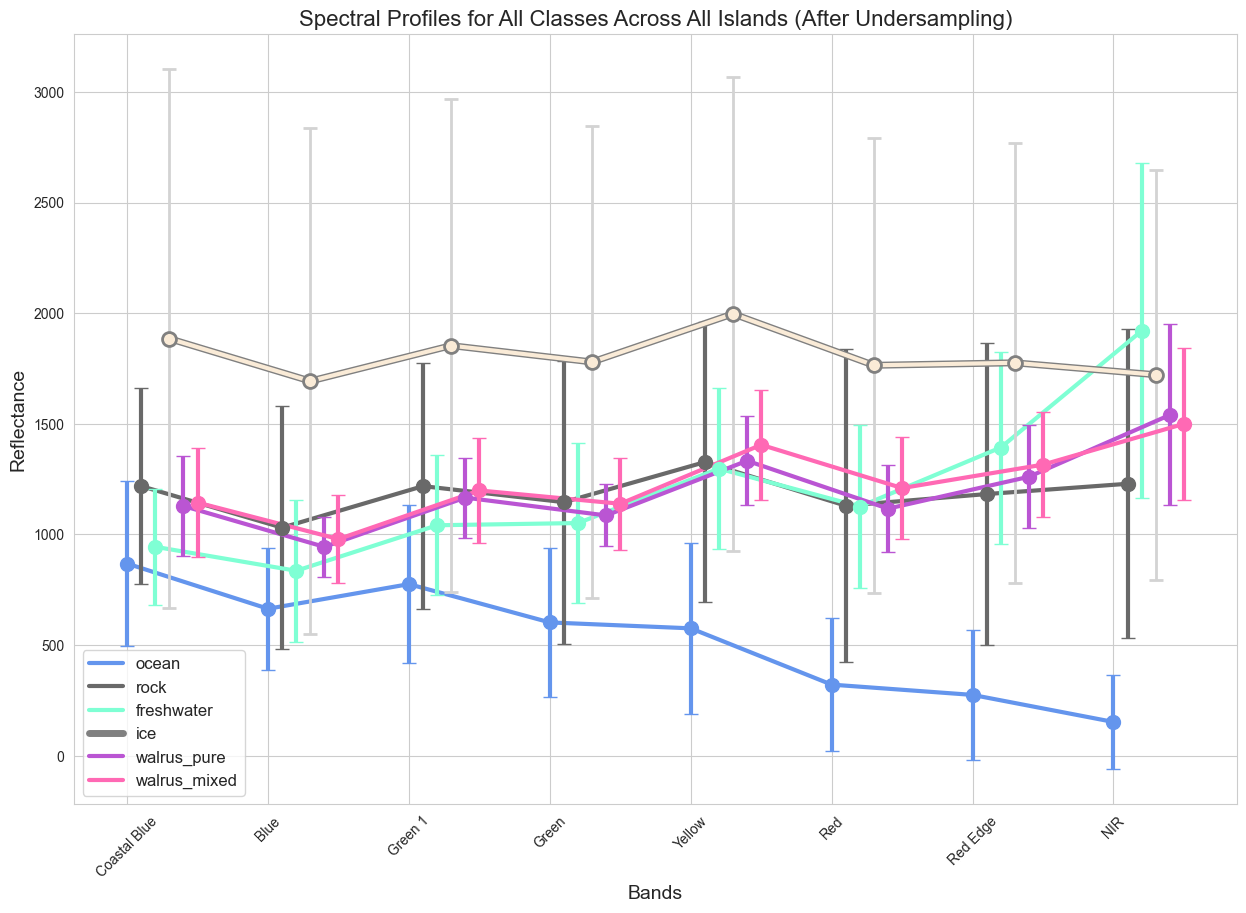

In [111]:
# Calculate mean and std profiles for undersampled data
undersampled_mean_profiles = []
undersampled_std_profiles = []

for label in unique_labels:
    class_data = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].values
    undersampled_mean_profiles.append(class_data.mean(axis=0))
    undersampled_std_profiles.append(class_data.std(axis=0))

undersampled_mean_profiles = np.array(undersampled_mean_profiles)
undersampled_std_profiles = np.array(undersampled_std_profiles)

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = undersampled_mean_profiles[class_index]
    std = undersampled_std_profiles[class_index]
    offset = class_index * staggering_factor
    color = label_colors.get(class_label, 'black')
    
    # Plot mean line with grey outline for 'ice' class
    if class_label == 'ice':
        plt.plot(bands + offset, mean, label=class_label, color='grey', linewidth=5)
        plt.plot(bands + offset, mean, color=color, linewidth=3)
        plt.errorbar(bands + offset, mean, yerr=std, color=color, fmt='o', capsize=5, markersize=10, ecolor='lightgrey', elinewidth=2, markeredgewidth=2, markeredgecolor='grey')
    else:
        plt.plot(bands + offset, mean, label=class_label, color=color, linewidth=3)
        plt.errorbar(bands + offset, mean, yerr=std, color=color, fmt='o', capsize=5, markersize=10, elinewidth=3)

plt.xticks(ticks=bands, labels=band_names, rotation=45)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands (After Undersampling)', fontsize=16)
plt.legend(fontsize=12)
plt.show()


In [92]:
band_names = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

def format_means(means):
    return [f"{m:.4f}" for m in means]

comparison_data = []

for label in unique_labels:
    original_mean = dataset[dataset['labels'] == label].iloc[:, :8].mean().values
    undersampled_mean = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].mean().values
    
    comparison_data.append({
        'Class': label,
        'Dataset': 'Original',
        **dict(zip(band_names, format_means(original_mean)))
    })
    comparison_data.append({
        'Class': label,
        'Dataset': 'Undersampled',
        **dict(zip(band_names, format_means(undersampled_mean)))
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index(['Class', 'Dataset'])

print(comparison_df)

# Calculate and display the differences
diff_data = []
for label in unique_labels:
    original_mean = dataset[dataset['labels'] == label].iloc[:, :8].mean().values
    undersampled_mean = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].mean().values
    diff = undersampled_mean - original_mean
    
    diff_data.append({
        'Class': label,
        'Dataset': 'Difference',
        **dict(zip(band_names, format_means(diff)))
    })

diff_df = pd.DataFrame(diff_data)
diff_df = diff_df.set_index(['Class', 'Dataset'])

print("\nDifferences (Undersampled - Original):")
print(diff_df)

# Calculate and display the percent differences
percent_diff_data = []
for label in unique_labels:
    original_mean = dataset[dataset['labels'] == label].iloc[:, :8].mean().values
    undersampled_mean = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].mean().values
    percent_diff = ((undersampled_mean - original_mean) / original_mean) * 100
    
    percent_diff_data.append({
        'Class': label,
        'Dataset': 'Percent Difference',
        **dict(zip(band_names, [f"{pd:.2f}%" for pd in percent_diff]))
    })

percent_diff_df = pd.DataFrame(percent_diff_data)
percent_diff_df = percent_diff_df.set_index(['Class', 'Dataset'])

print("\nPercent Differences:")
print(percent_diff_df)

                          Coast_blue       Blue     Green1      Green  \
Class        Dataset                                                    
ocean        Original       893.9110   706.6451   837.7459   677.4760   
             Undersampled   868.1727   664.0864   775.3182   602.2591   
rock         Original      1219.7976   799.3340  1028.4945   818.6901   
             Undersampled  1218.2879  1030.6591  1218.2500  1145.8182   
freshwater   Original       952.8863   772.7887  1012.9632   956.7318   
             Undersampled   944.0152   835.7197  1041.4167  1051.4091   
ice          Original      1994.5828  1858.5116  2066.2924  2044.0502   
             Undersampled  1884.6636  1692.9636  1853.2545  1779.4045   
walrus_pure  Original      1101.8468   943.2703  1151.6306  1079.7523   
             Undersampled  1128.3712   943.7273  1166.2803  1085.7652   
walrus_mixed Original      1145.9916  1029.9832  1236.2078  1195.4026   
             Undersampled  1143.9455   978.9636  11

In [94]:
print("Number of pixels by class for each island before undersampling:")
island_class_counts_before = {}
for island in islands:
    island_data = dataset[dataset['image_name'].str.contains(island)]
    island_class_counts_before[island] = island_data['labels'].value_counts()

for island, counts in island_class_counts_before.items():
    print(f"\nIsland: {island}")
    print(counts)

Number of pixels by class for each island before undersampling:

Island: buch
labels
ocean           313885
ice             195822
freshwater       34517
rock              9291
walrus_mixed       349
walrus_pure         70
Name: count, dtype: int64

Island: moff
labels
ocean           55129
ice             12090
freshwater        244
walrus_mixed       44
Name: count, dtype: int64

Island: pal
labels
rock            82490
ocean           77962
ice              9788
walrus_mixed      188
walrus_pure        61
Name: count, dtype: int64

Island: sars
labels
ocean           143231
ice               5789
walrus_mixed       188
Name: count, dtype: int64

Island: tor
labels
ocean           189081
ice              76742
freshwater        5490
rock              1075
walrus_mixed       540
walrus_pure         91
Name: count, dtype: int64


In [95]:
# Dictionary to store the desired number of pixels for each class by island
island_desired_counts = {
    'buch': {'walrus_mixed': 349, 'walrus_pure': 70, 'ocean': 550, 'rock': 550, 'freshwater': 550, 'ice': 550},
    'moff': {'walrus_mixed': 44, 'walrus_pure': None, 'ocean': 550, 'rock': None, 'freshwater': 244, 'ice': 550},
    'pal': {'walrus_mixed': 188, 'walrus_pure': 61, 'ocean': 550, 'rock': 550, 'freshwater': None, 'ice': 550},
    'sars': {'walrus_mixed': 188, 'walrus_pure': None, 'ocean': 550, 'rock': None, 'freshwater': None, 'ice': 550},
    'tor': {'walrus_mixed': 540, 'walrus_pure': 91, 'ocean': 550, 'rock': 550, 'freshwater': 500, 'ice': 500}
}

In [96]:
# Step 6: Undersample by island and replot island-by-island comparisons
island_undersampled_data = []

# Dictionary to store class counts by island
island_class_counts = {}

for island in islands:
    island_data = dataset[dataset['image_name'].str.contains(island)]
    island_undersampled_classes = []

    if island in island_desired_counts:
        for label, desired_count in island_desired_counts[island].items():
            class_data = island_data[island_data['labels'] == label]
            if len(class_data) > 0:
                # Determine the number of samples to use
                if desired_count is None:
                    n_samples = len(class_data)  # Use all available pixels
                else:
                    n_samples = min(desired_count, len(class_data))
                
                island_undersampled_classes.append(resample(class_data, replace=False, n_samples=n_samples))
            else:
                continue

    undersampled_island_df = pd.concat(island_undersampled_classes) if island_undersampled_classes else pd.DataFrame(columns=dataset.columns)
    island_undersampled_data.append(undersampled_island_df)

    # Count the number of pixels for each class in this island
    island_class_counts[island] = undersampled_island_df['labels'].value_counts()

island_undersampled_dataset = pd.concat(island_undersampled_data)

# Print the pixel count by island after undersampling
print("Number of pixels after undersampling by island:")
for island, counts in island_class_counts.items():
    print(f"\nIsland: {island}")
    print(counts)

Number of pixels after undersampling by island:

Island: buch
labels
ocean           550
rock            550
freshwater      550
ice             550
walrus_mixed    349
walrus_pure      70
Name: count, dtype: int64

Island: moff
labels
ocean           550
ice             550
freshwater      244
walrus_mixed     44
Name: count, dtype: int64

Island: pal
labels
ocean           550
rock            550
ice             550
walrus_mixed    188
walrus_pure      61
Name: count, dtype: int64

Island: sars
labels
ocean           550
ice             550
walrus_mixed    188
Name: count, dtype: int64

Island: tor
labels
ocean           550
rock            550
walrus_mixed    540
freshwater      500
ice             500
walrus_pure      91
Name: count, dtype: int64


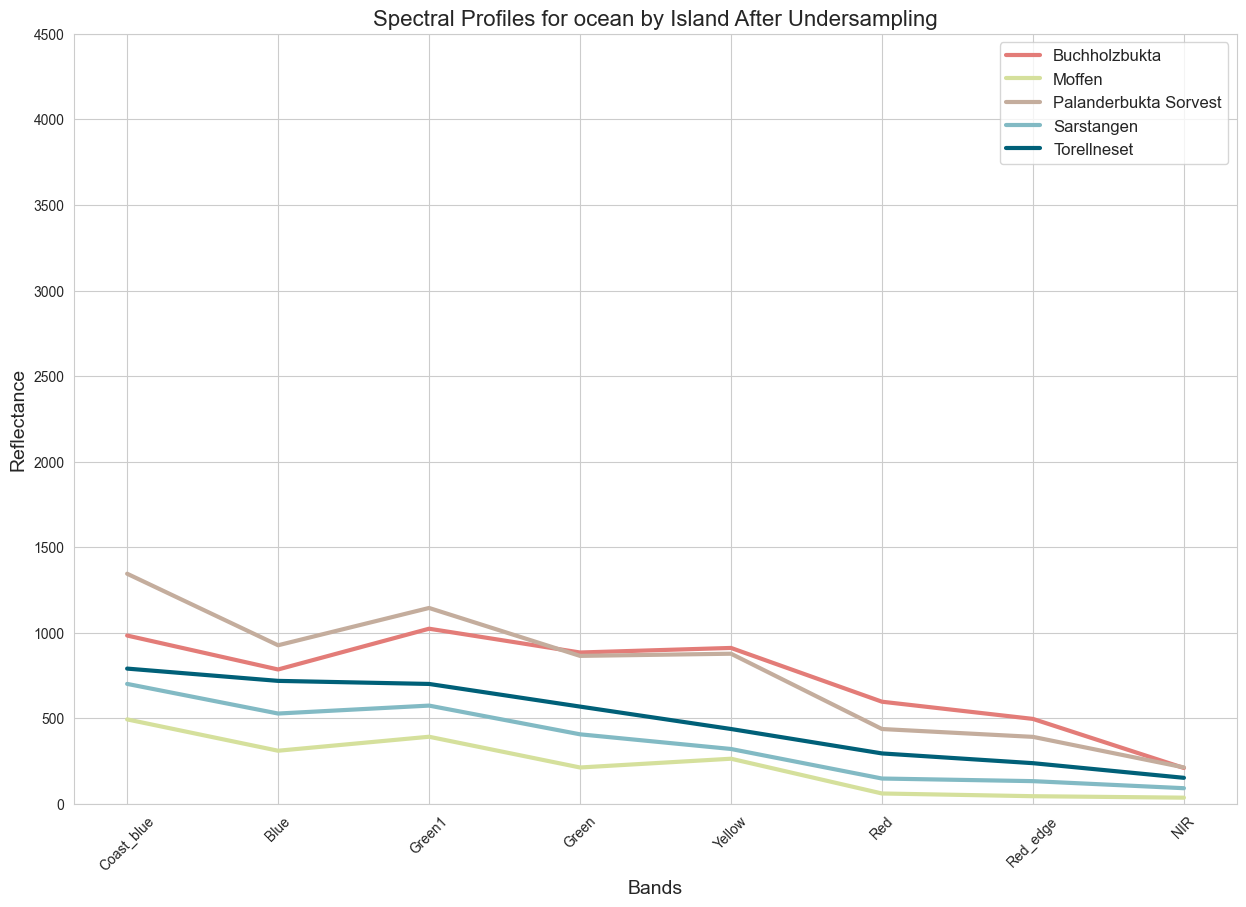

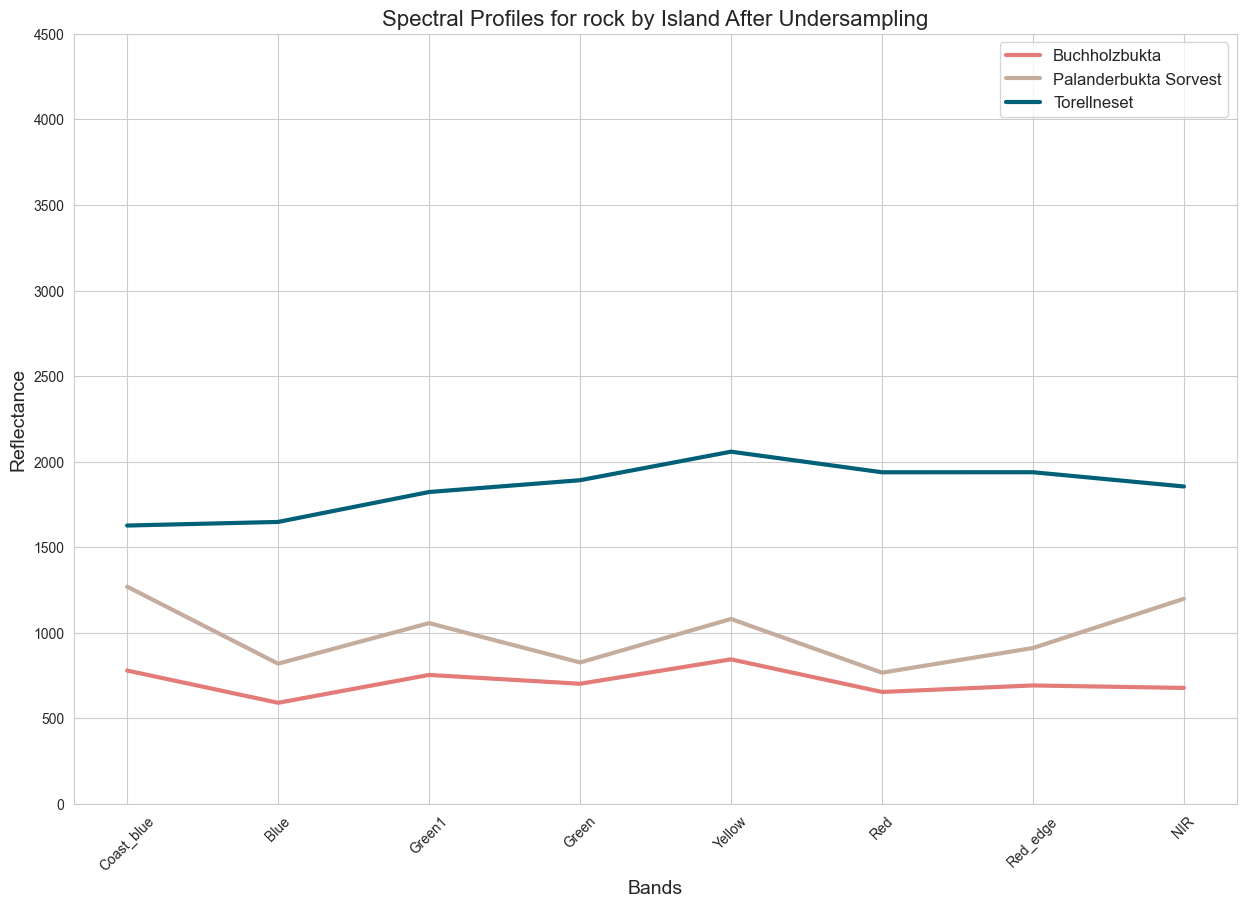

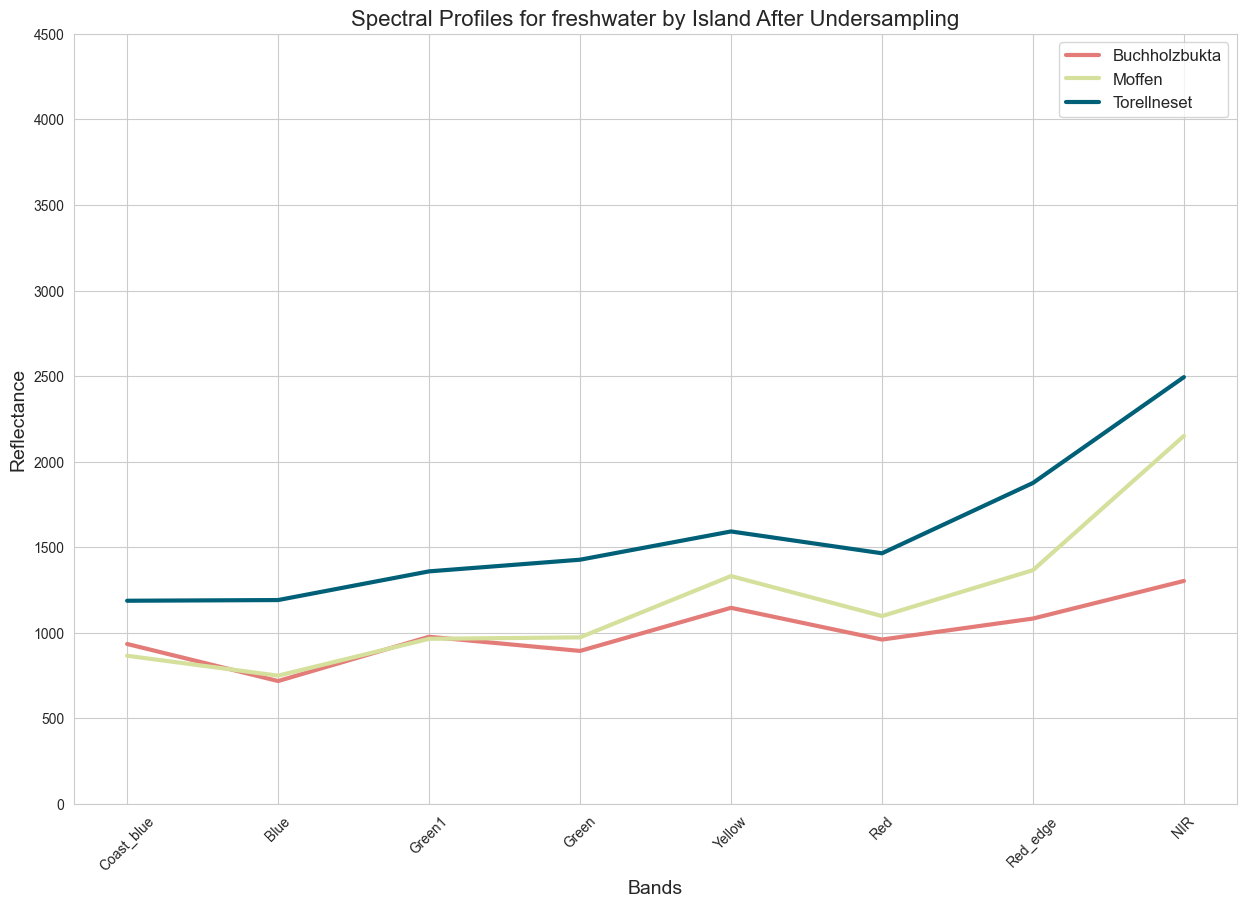

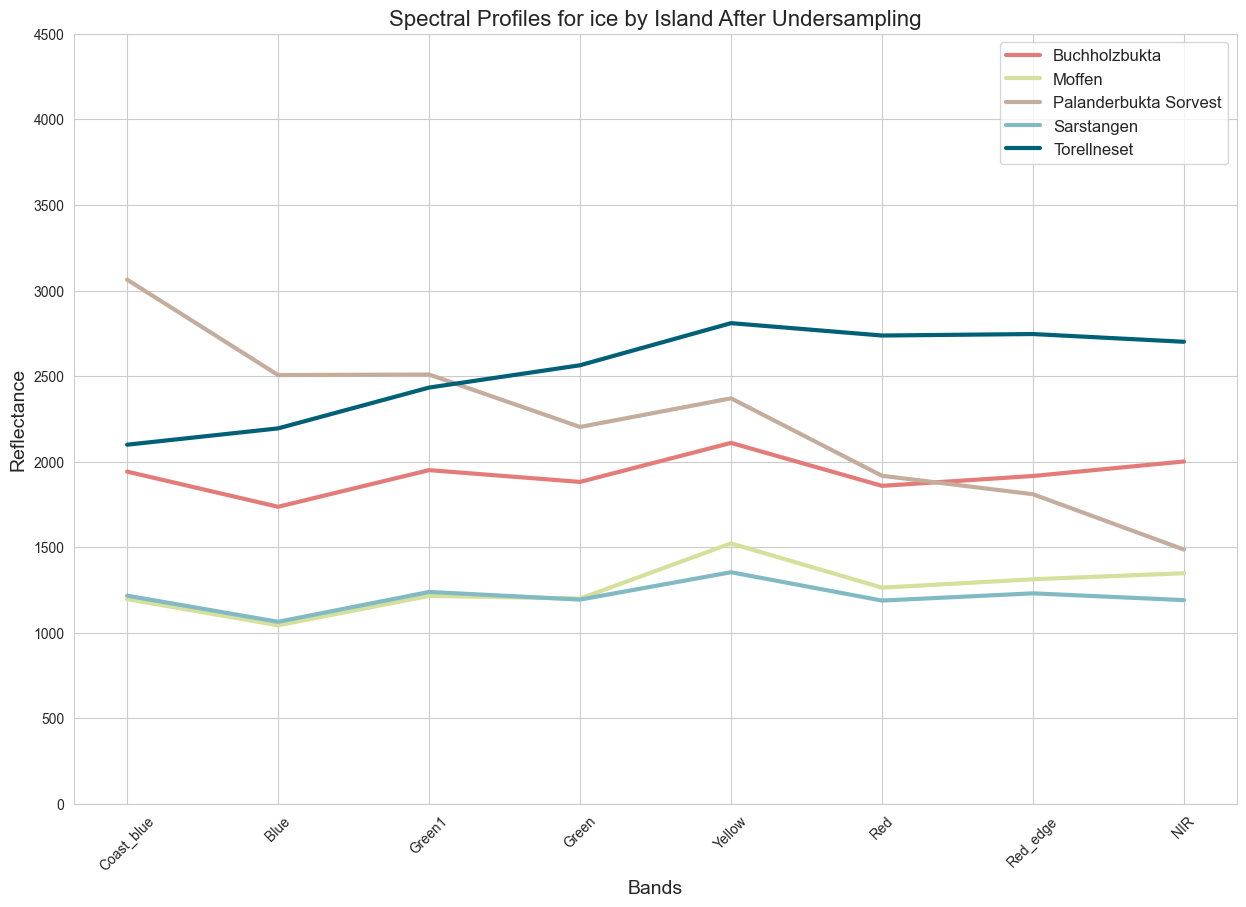

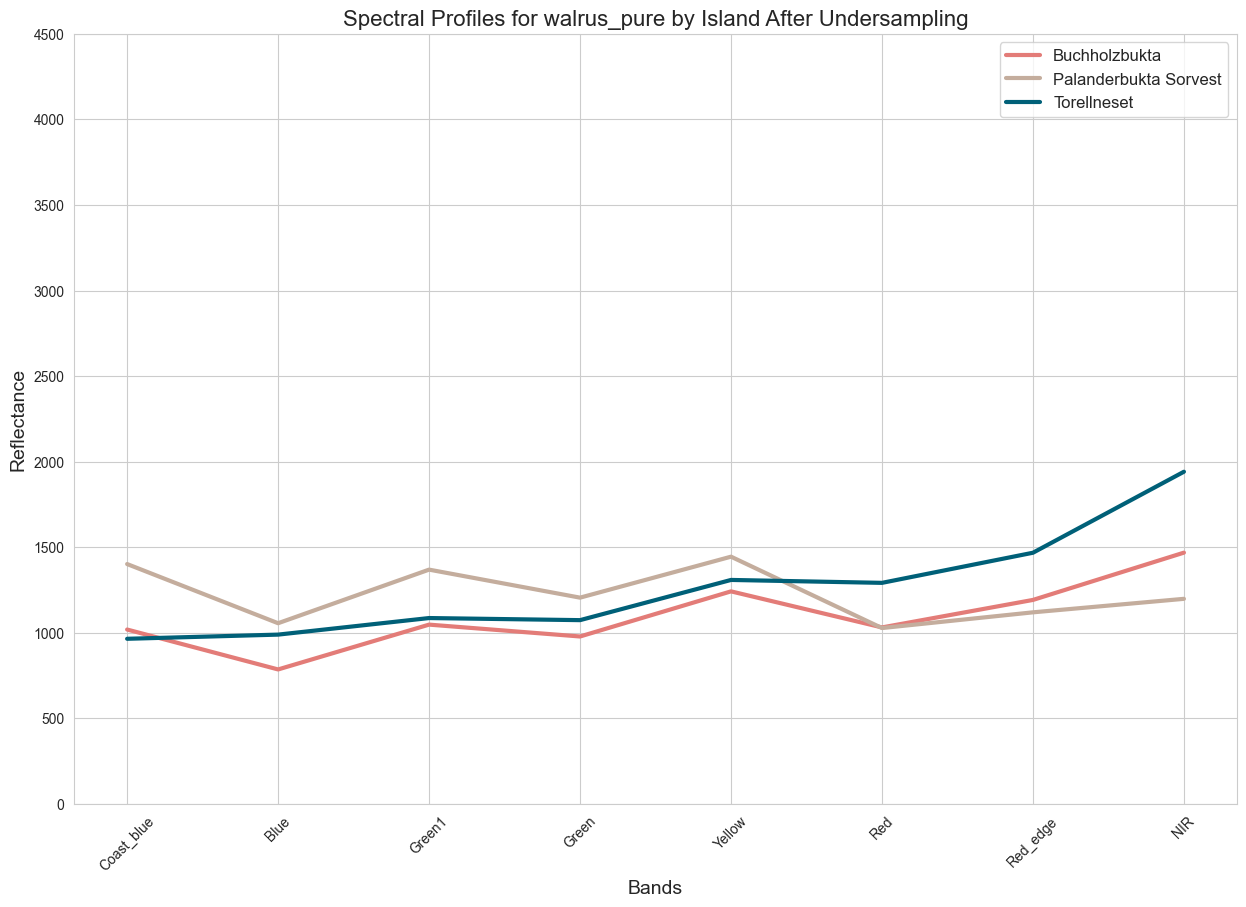

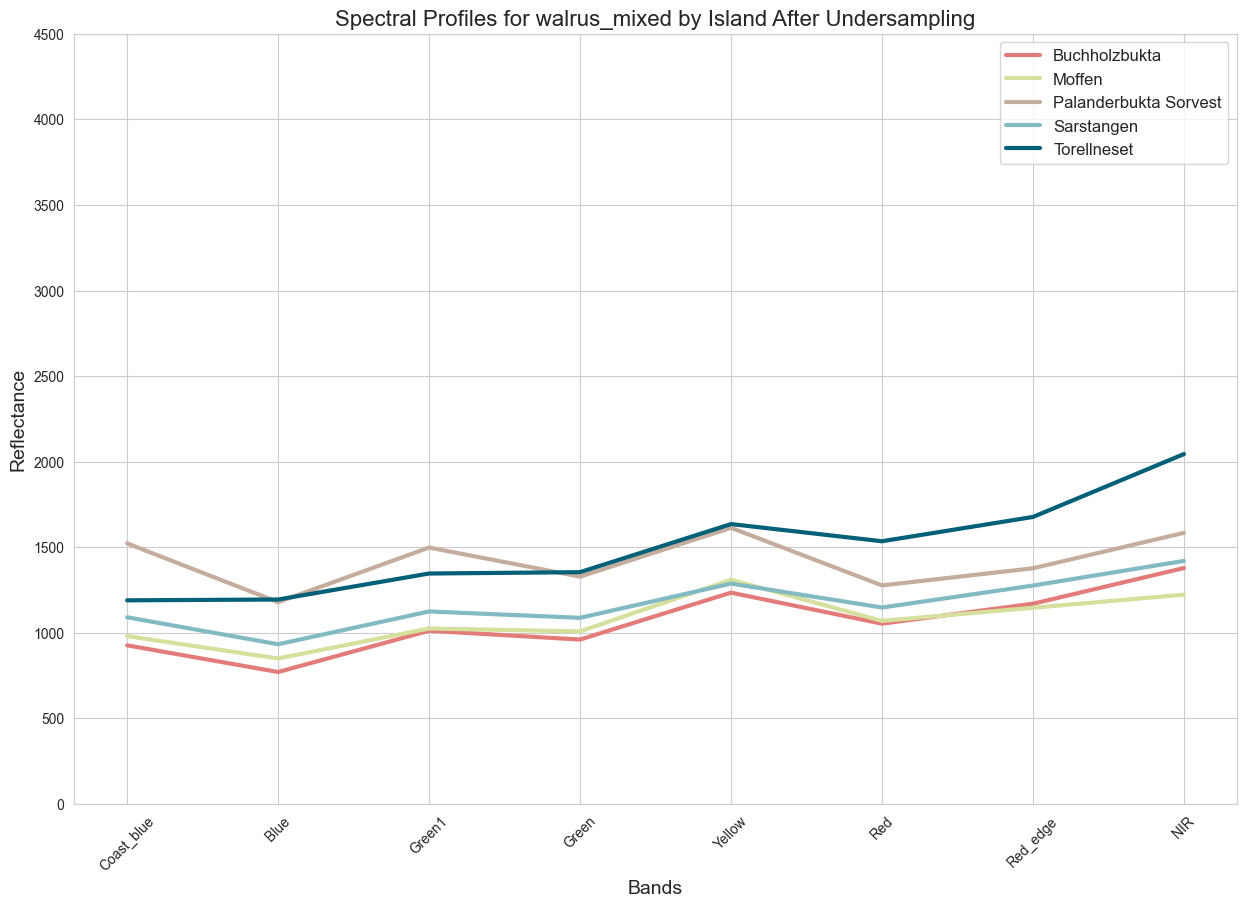

In [99]:
# Define color palette similar to the provided image
island_colors = {
    'buch': '#E37C78',  # Buchholzbukta
    'moff': '#D5E09C',  # Moffen
    'pal': '#C4AD9D',  # Palanderbukta Sorvest
    'sars': '#82BAC4',  # Sarstangen
    'tor': '#006078'   # Torellneset
}

# Define a mapping from island identifiers to descriptive names
island_names = {
    'buch': 'Buchholzbukta',
    'moff': 'Moffen',
    'pal': 'Palanderbukta Sorvest',
    'sars': 'Sarstangen',
    'tor': 'Torellneset'
}

# Plot spectral profiles for each class by island after undersampling
for class_label in unique_labels:
    plt.figure(figsize=(15, 10))
    for i, island in enumerate(islands):
        island_class_data = island_undersampled_dataset[(island_undersampled_dataset['labels'] == class_label) & (island_undersampled_dataset['image_name'].str.contains(island))].iloc[:, :8].values
        if island_class_data.shape[0] > 0:
            mean = island_class_data.mean(axis=0)
            std = island_class_data.std(axis=0)
            plt.plot(bands, mean, label=island_names[island], color=list(island_colors.values())[i], linewidth=3)
          

    plt.ylim(0, 4500)
    plt.xticks(ticks=bands, labels=band_names, rotation=45)
    plt.xlabel('Bands', fontsize=14)
    plt.ylabel('Reflectance', fontsize=14)
    plt.title(f'Spectral Profiles for {class_label} by Island After Undersampling', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.utils import resample
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib
from rasterio.mask import geometry_mask
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, precision_recall_curve
from sklearn.utils import resample
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(all_image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in all_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(all_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

print("Total images:", len(all_image_paths))
print("Images paired with shapefiles:", len(file_pairs))
print("Images with general shapefiles:", sum(1 for _, (gen, _) in file_pairs.items() if gen is not None))
print("Images with walrus shapefiles:", sum(1 for _, (_, wal) in file_pairs.items() if wal is not None))

for island in set(extract_island_and_date(os.path.basename(img))[0] for img in all_image_paths):
    island_pairs = {img: shp for img, shp in file_pairs.items() if extract_island_and_date(os.path.basename(img))[0] == island}
    print(f"\n{island}:")
    print(f"  Total images: {sum(1 for img in all_image_paths if extract_island_and_date(os.path.basename(img))[0] == island)}")
    print(f"  Paired images: {len(island_pairs)}")
    print(f"  With general shapefiles: {sum(1 for _, (gen, _) in island_pairs.items() if gen is not None)}")
    print(f"  With walrus shapefiles: {sum(1 for _, (_, wal) in island_pairs.items() if wal is not None)}")

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

Total images: 30
Images paired with shapefiles: 20
Images with general shapefiles: 14
Images with walrus shapefiles: 10

moff:
  Total images: 1
  Paired images: 1
  With general shapefiles: 1
  With walrus shapefiles: 0

pool:
  Total images: 1
  Paired images: 0
  With general shapefiles: 0
  With walrus shapefiles: 0

sars:
  Total images: 5
  Paired images: 2
  With general shapefiles: 2
  With walrus shapefiles: 2

buch:
  Total images: 6
  Paired images: 6
  With general shapefiles: 4
  With walrus shapefiles: 3

tor:
  Total images: 9
  Paired images: 8
  With general shapefiles: 4
  With walrus shapefiles: 5

pal:
  Total images: 8
  Paired images: 3
  With general shapefiles: 3
  With walrus shapefiles: 0


In [42]:
# Step 2: Compute total number of pixels in each class
class_counts = dataset['labels'].value_counts()
print("Total number of pixels in each class:")
print(class_counts)

Total number of pixels in each class:
labels
ocean           779288
ice             300231
rock             92856
freshwater       40251
walrus_mixed      1309
walrus_pure        222
Name: count, dtype: int64


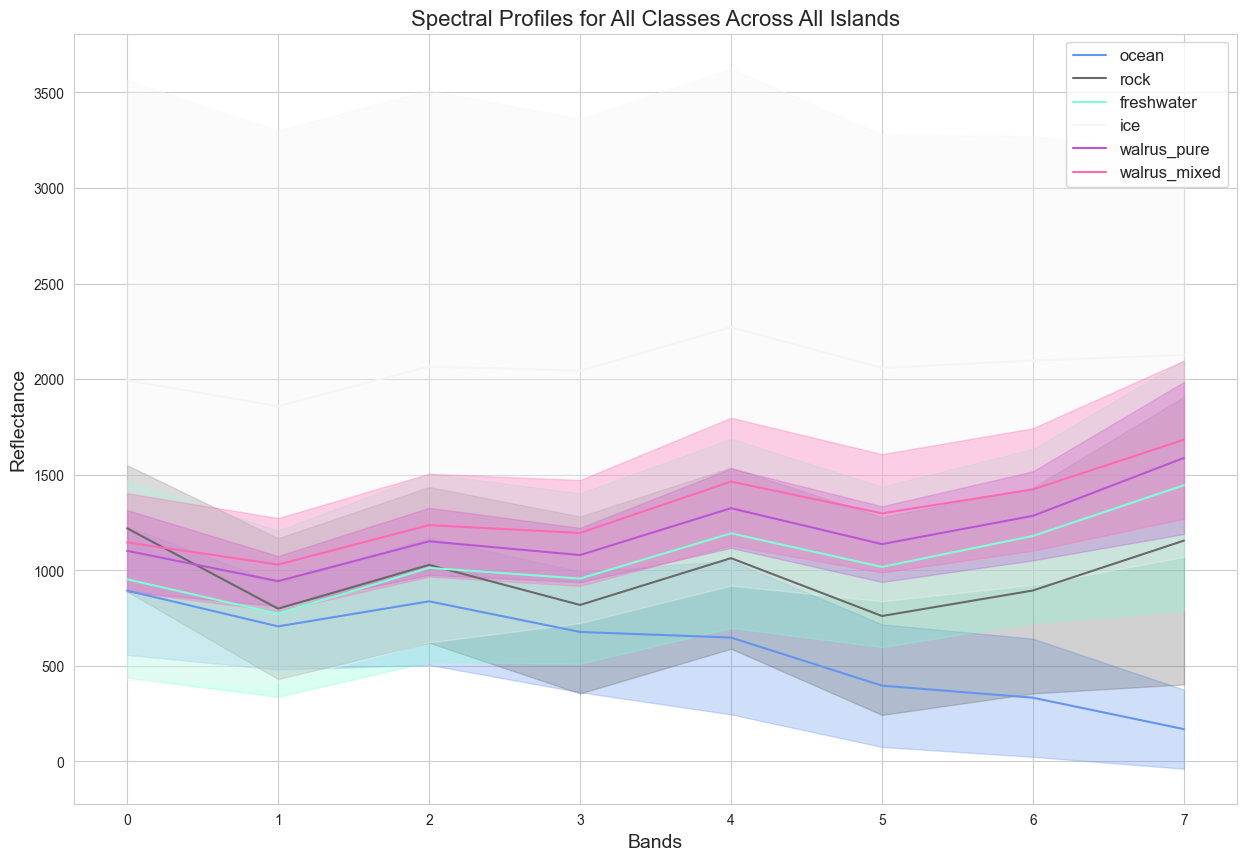

In [43]:
# Step 3: Plot spectral signatures for all classes across all islands
unique_labels = dataset['labels'].unique()
bands = np.arange(features.shape[1])
mean_profiles = []
std_profiles = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    plt.plot(bands, mean, label=class_label, color=label_colors.get(class_label, 'black'))
    plt.fill_between(bands, mean - std, mean + std, color=label_colors.get(class_label, 'black'), alpha=0.3)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands', fontsize=16)
plt.legend(fontsize=12)
plt.show()

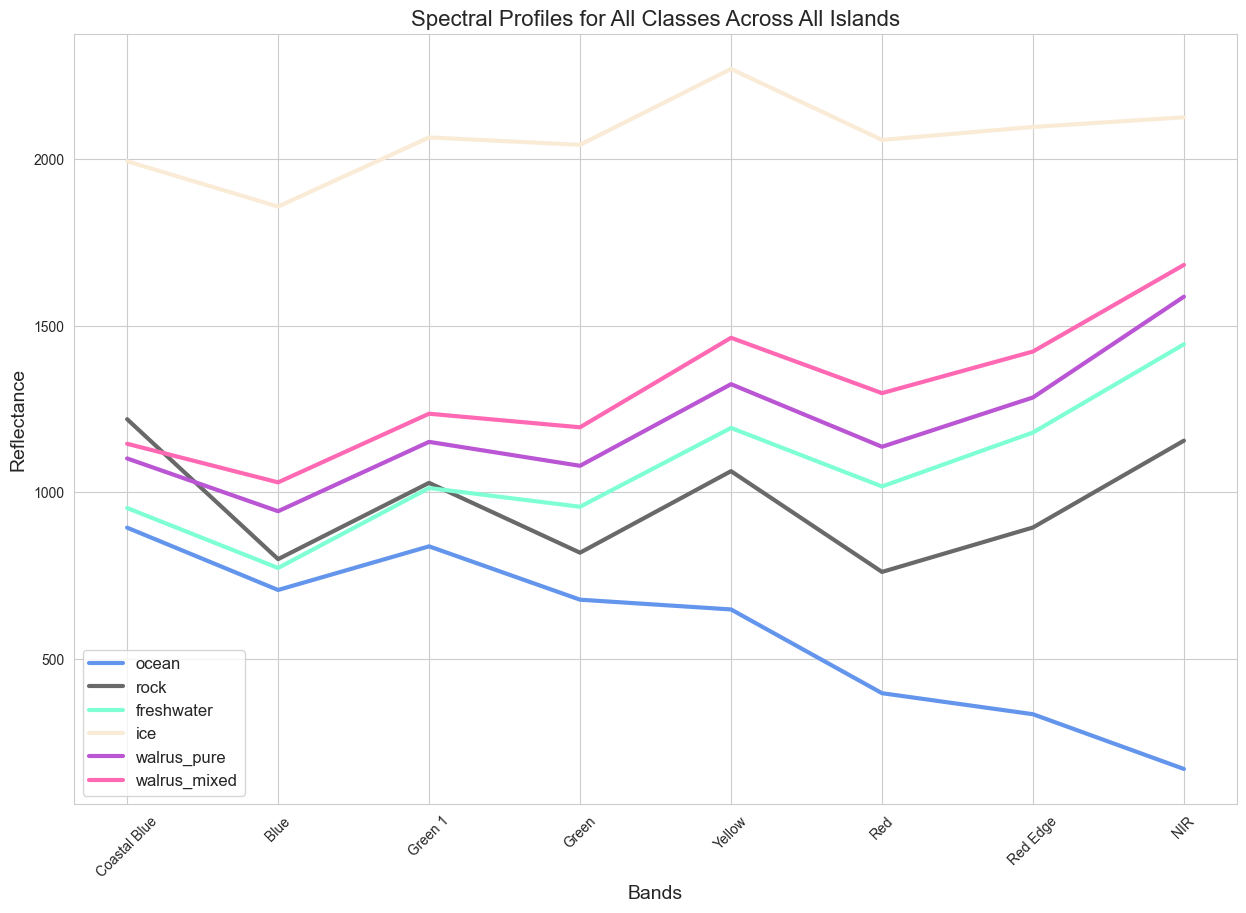

In [67]:
# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Step 3: Plot spectral signatures for all classes across all islands
# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  # Coastal Blue
    'Blue': (465, 515),  # Blue
    'Green 1': (513, 549),  # Green 1
    'Green': (547, 583),  # Green
    'Yellow': (600, 620),  # Yellow
    'Red': (630, 680),  # Red
    'Red Edge': (697, 713),  # Red Edge
    'NIR': (845, 885)   # NIR
}

# Assuming the dataset is already loaded
unique_labels = dataset['labels'].unique()
bands = np.arange(features.shape[1])
mean_profiles = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))

mean_profiles = np.array(mean_profiles)

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    plt.plot(bands, mean, label=class_label, color=label_colors.get(class_label, 'black'), linewidth=3)  # Thicker line

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands', fontsize=16)
plt.legend(fontsize=12)
plt.show()

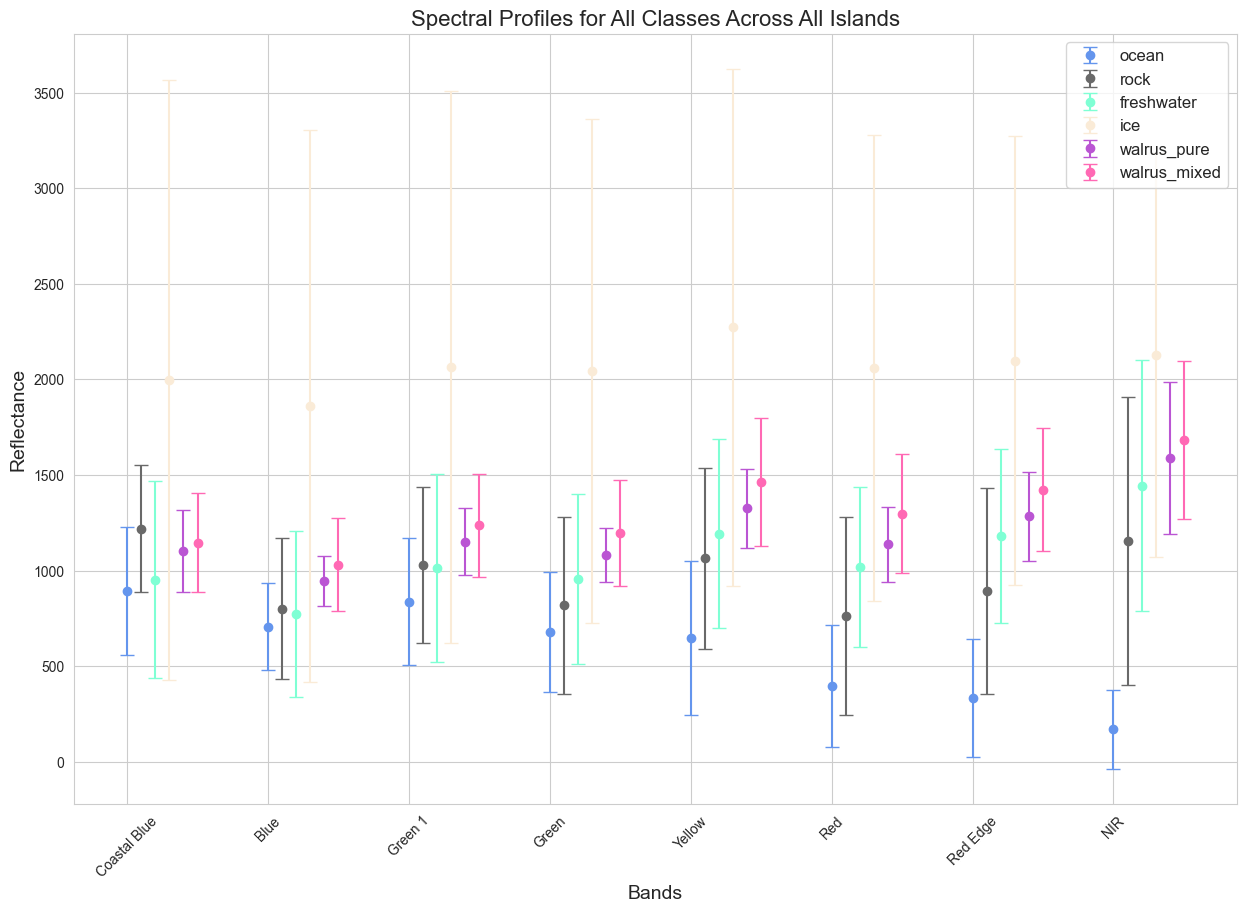

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  # Coastal Blue
    'Blue': (465, 515),  # Blue
    'Green 1': (513, 549),  # Green 1
    'Green': (547, 583),  # Green
    'Yellow': (600, 620),  # Yellow
    'Red': (630, 680),  # Red
    'Red Edge': (697, 713),  # Red Edge
    'NIR': (845, 885)   # NIR
}

# Assuming the dataset is already loaded
unique_labels = dataset['labels'].unique()
bands = np.arange(features.shape[1])
mean_profiles = []
std_profiles = []

# Calculate mean and std profiles for each class
for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

# Staggering factor
staggering_factor = 0.1

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    offset = class_index * staggering_factor
    plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color=label_colors.get(class_label, 'black'), fmt='o', capsize=5)

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands', fontsize=16)
plt.legend(fontsize=12)
plt.show()


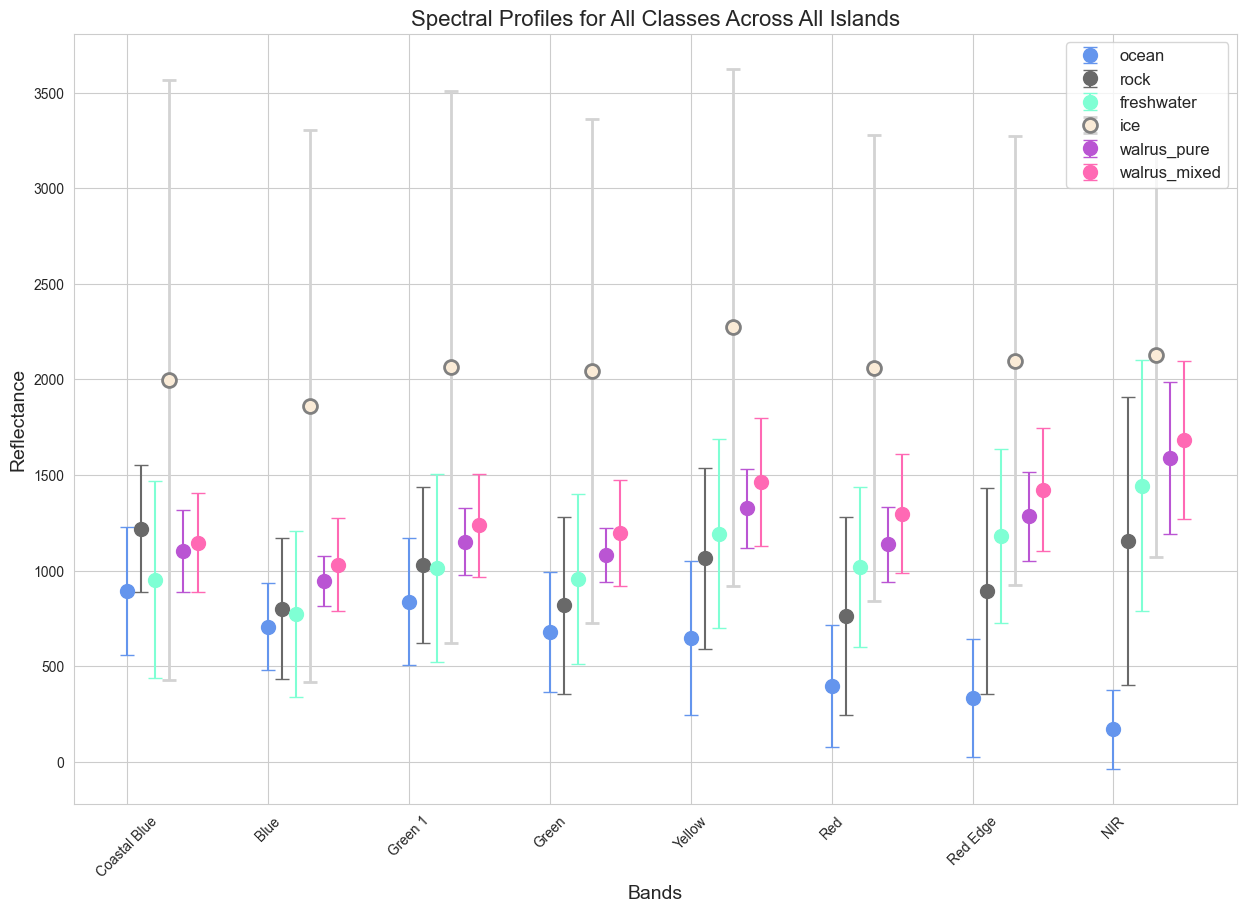

In [78]:
# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  # Coastal Blue
    'Blue': (465, 515),  # Blue
    'Green 1': (513, 549),  # Green 1
    'Green': (547, 583),  # Green
    'Yellow': (600, 620),  # Yellow
    'Red': (630, 680),  # Red
    'Red Edge': (697, 713),  # Red Edge
    'NIR': (845, 885)   # NIR
}

# Assuming the dataset is already loaded
unique_labels = dataset['labels'].unique()
bands = np.arange(features.shape[1])
mean_profiles = []
std_profiles = []

# Calculate mean and std profiles for each class
for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

# Staggering factor
staggering_factor = 0.1

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    offset = class_index * staggering_factor
    if class_label == 'ice':
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color='antiquewhite', fmt='o', capsize=5, markersize=10, ecolor='lightgrey', elinewidth=2, markeredgewidth=2, markeredgecolor='grey')
    else:
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color=label_colors.get(class_label, 'black'), fmt='o', capsize=5, markersize=10)

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands', fontsize=16)
plt.legend(fontsize=12)
plt.show()


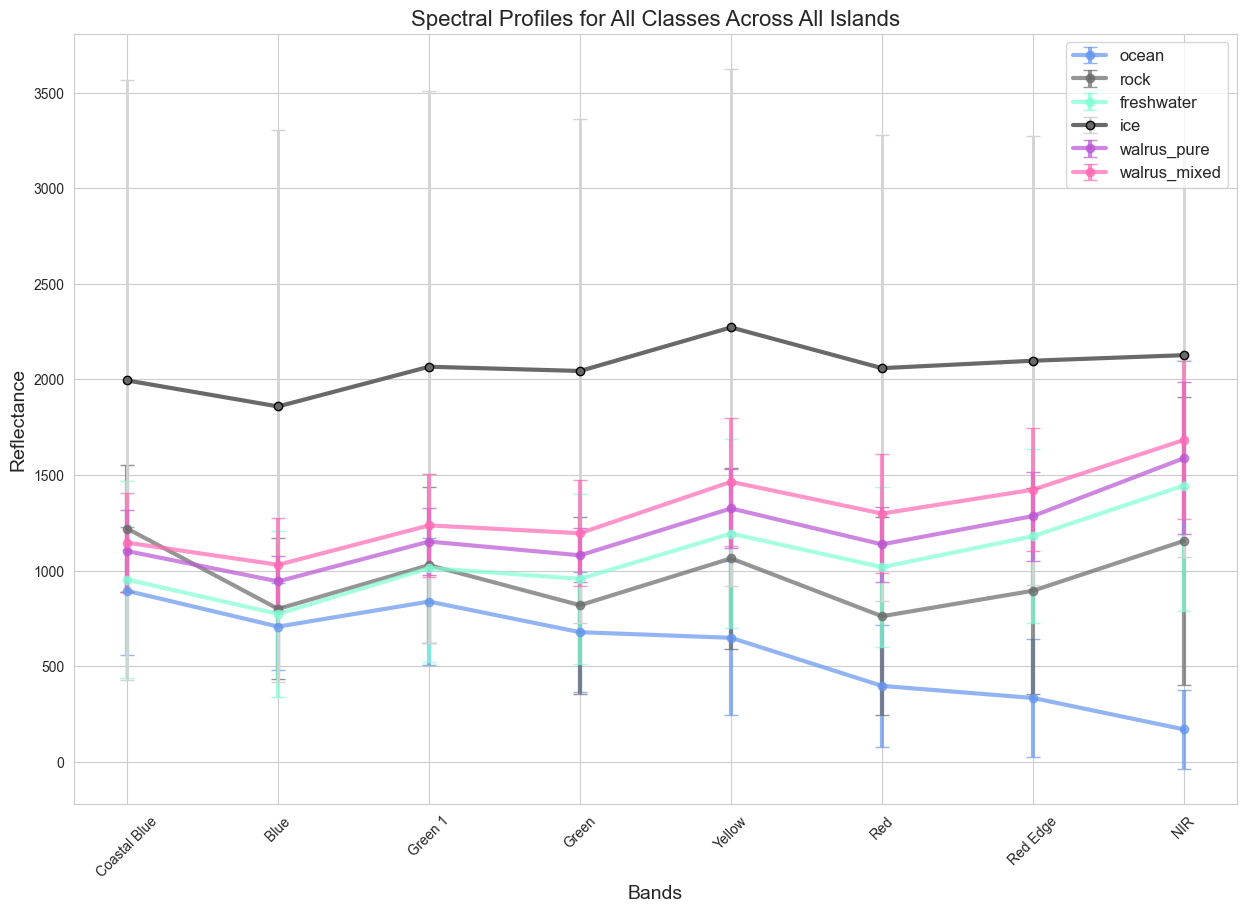

In [49]:
# Assuming the dataset is already loaded
unique_labels = dataset['labels'].unique()
bands = np.arange(features.shape[1])
mean_profiles = []
std_profiles = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    if class_label == 'ice':
        plt.errorbar(bands, mean, yerr=std, label=class_label, color='dimgrey', linewidth=3, fmt='-o', capsize=5, ecolor='lightgrey', elinewidth=2, markeredgecolor='black')  # Thicker line with error bars for ice
    else:
        plt.errorbar(bands, mean, yerr=std, label=class_label, color=label_colors.get(class_label, 'black'), linewidth=3, fmt='-o', capsize=5, alpha=0.7)  # Thicker line with error bars for other classes

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands', fontsize=16)
plt.legend(fontsize=12)
plt.show()

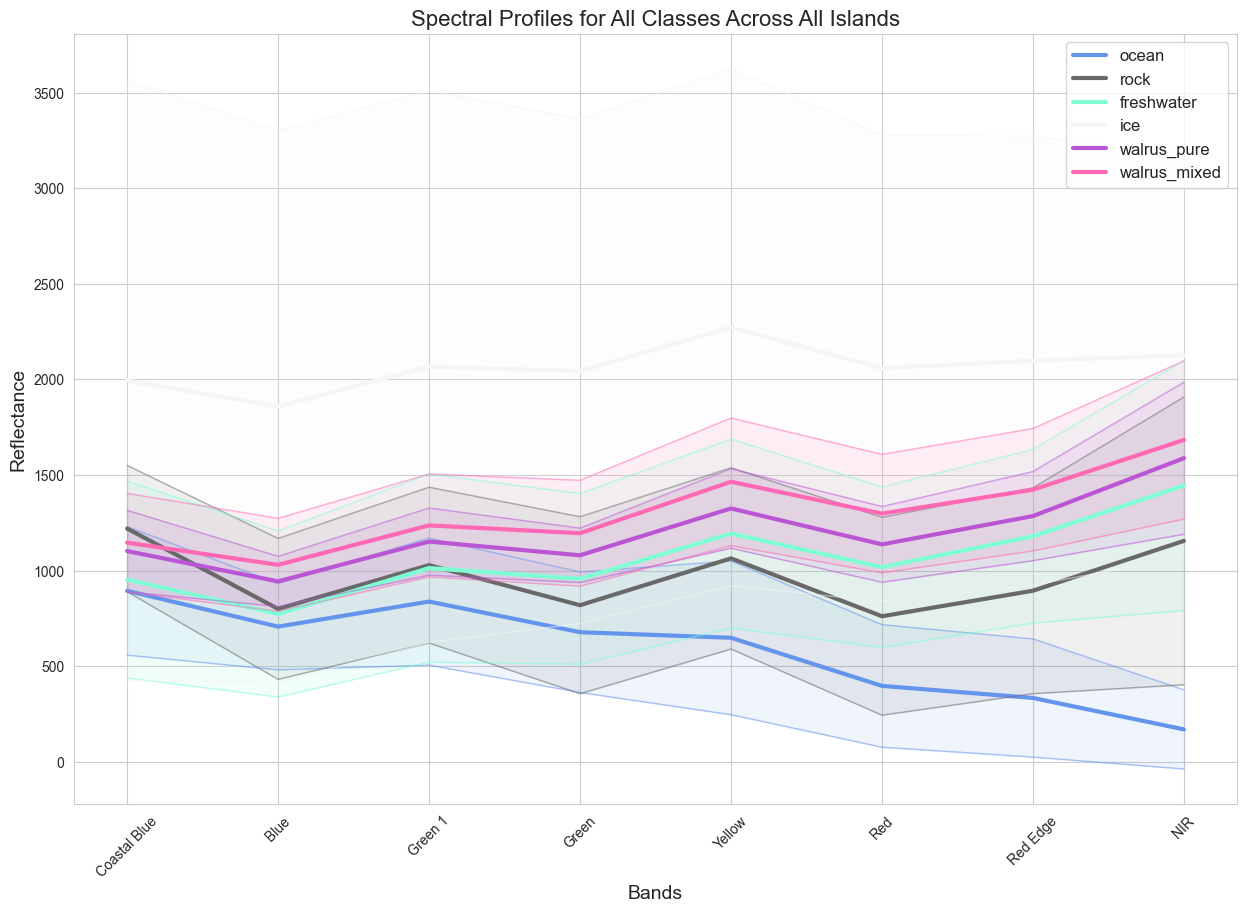

In [51]:
# Assuming the dataset is already loaded
unique_labels = dataset['labels'].unique()
bands = np.arange(features.shape[1])
mean_profiles = []
std_profiles = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    # Plot the shaded area for error bars
    plt.fill_between(bands, mean - std, mean + std, color=label_colors.get(class_label, 'black'), alpha=0.1)
    # Plot the outline for the error bars
    plt.plot(bands, mean - std, color=label_colors.get(class_label, 'black'), linewidth=1, alpha=0.5)
    plt.plot(bands, mean + std, color=label_colors.get(class_label, 'black'), linewidth=1, alpha=0.5)
    # Plot the mean line
    plt.plot(bands, mean, label=class_label, color=label_colors.get(class_label, 'black'), linewidth=3)  # Thicker line

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands', fontsize=16)
plt.legend(fontsize=12)
plt.show()

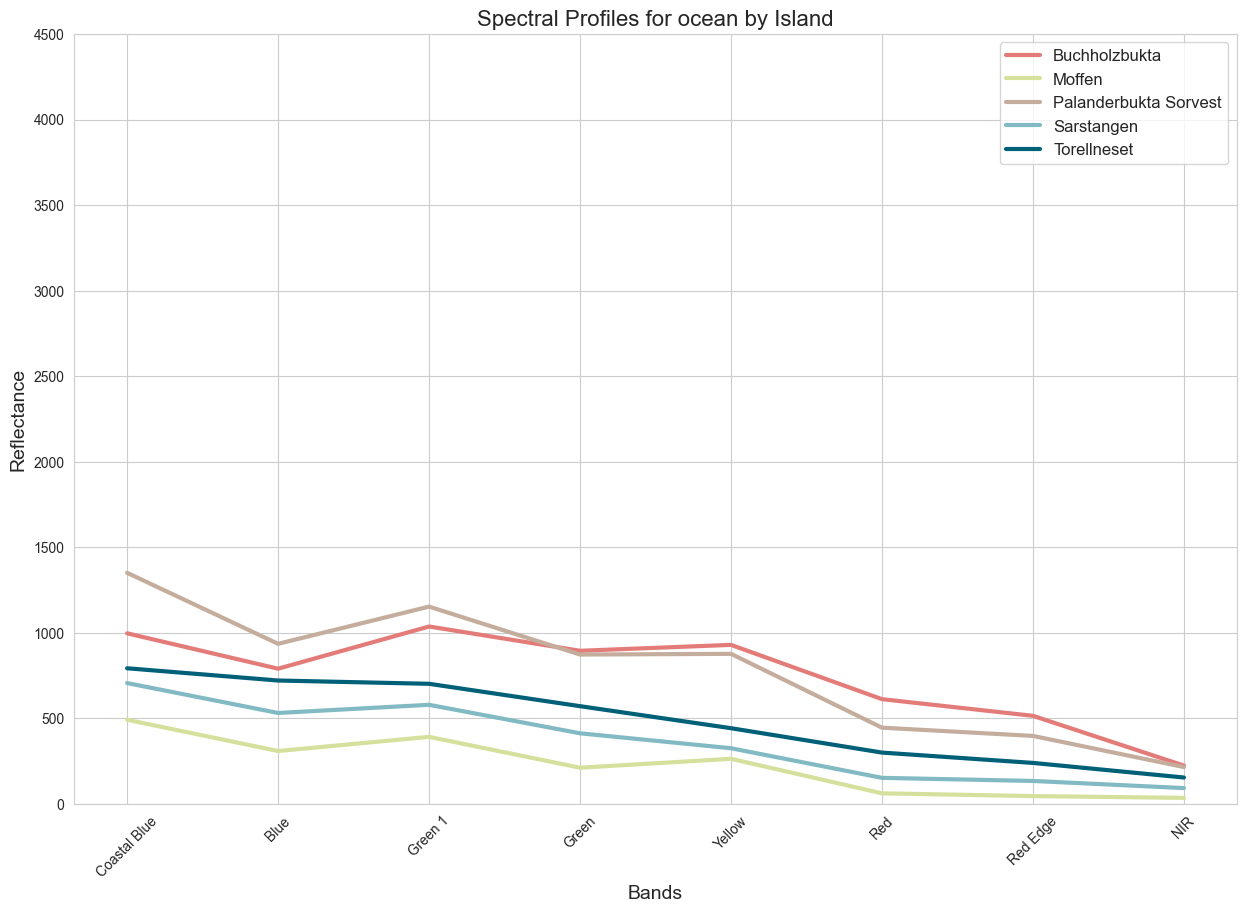

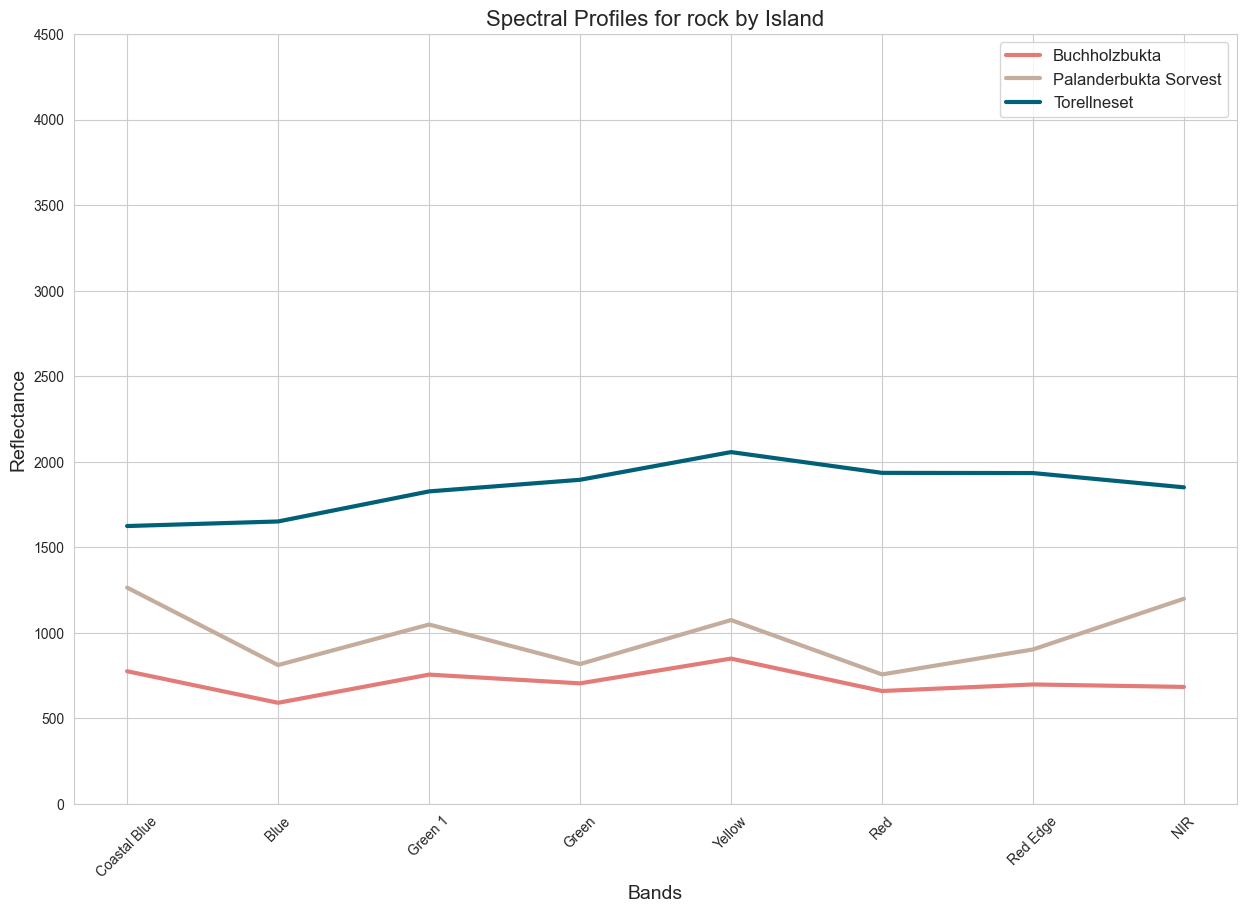

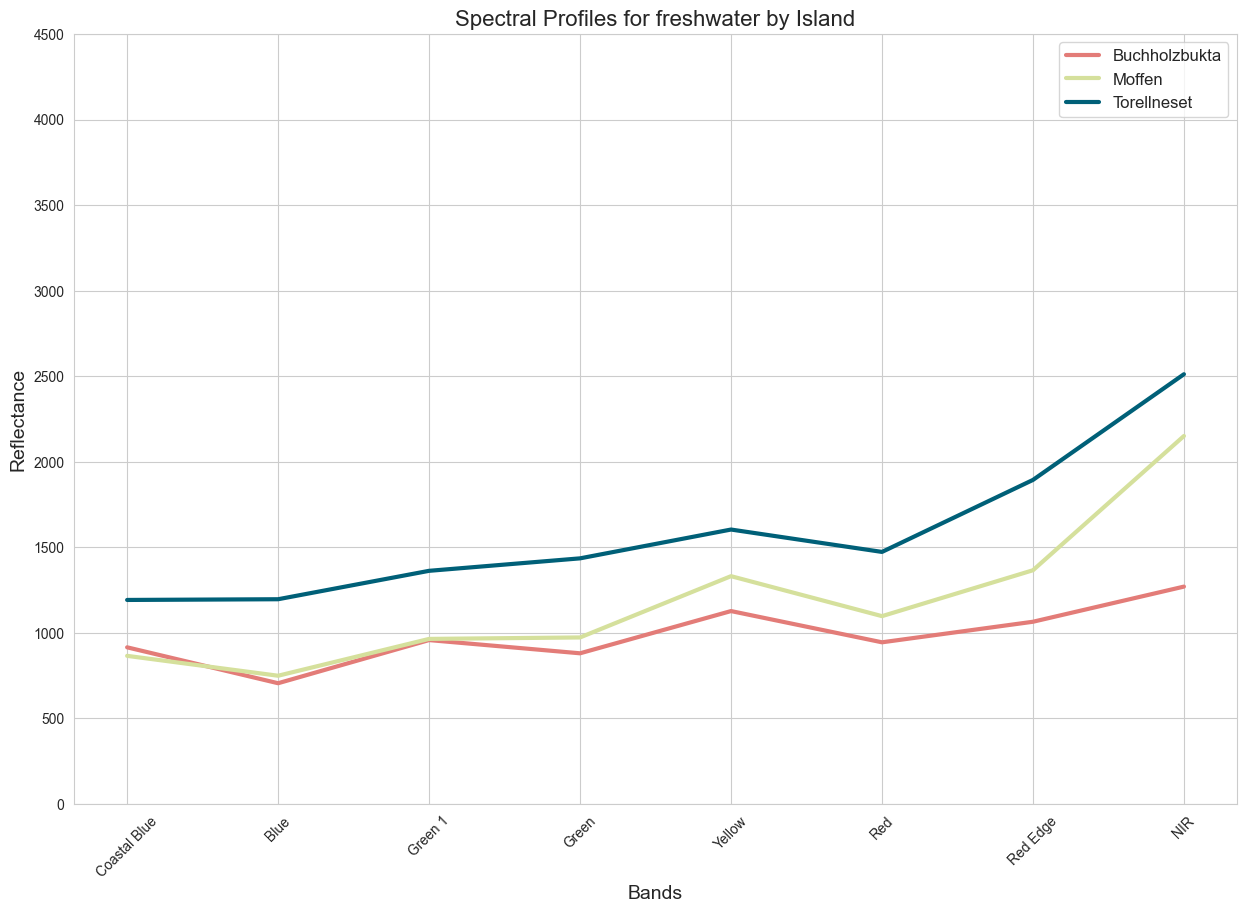

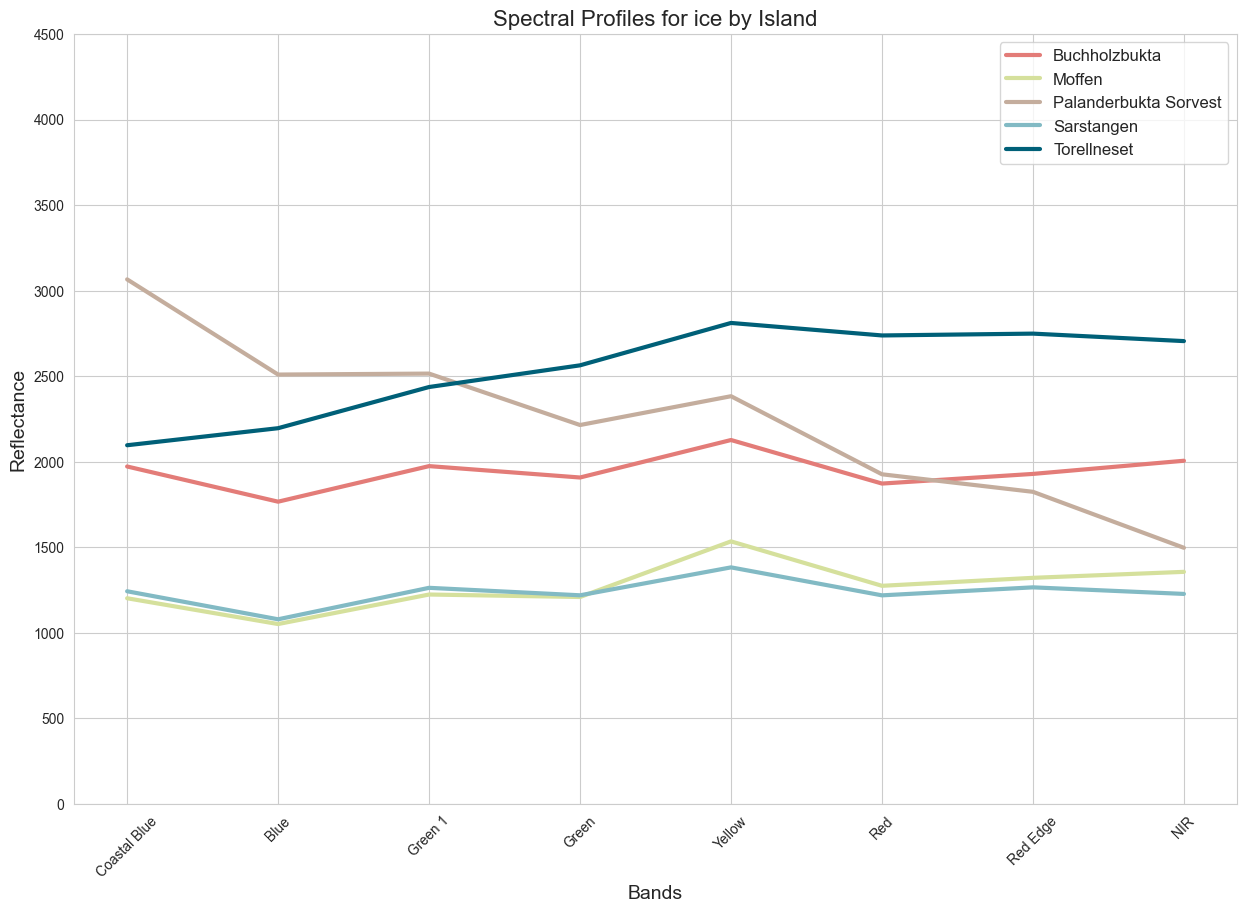

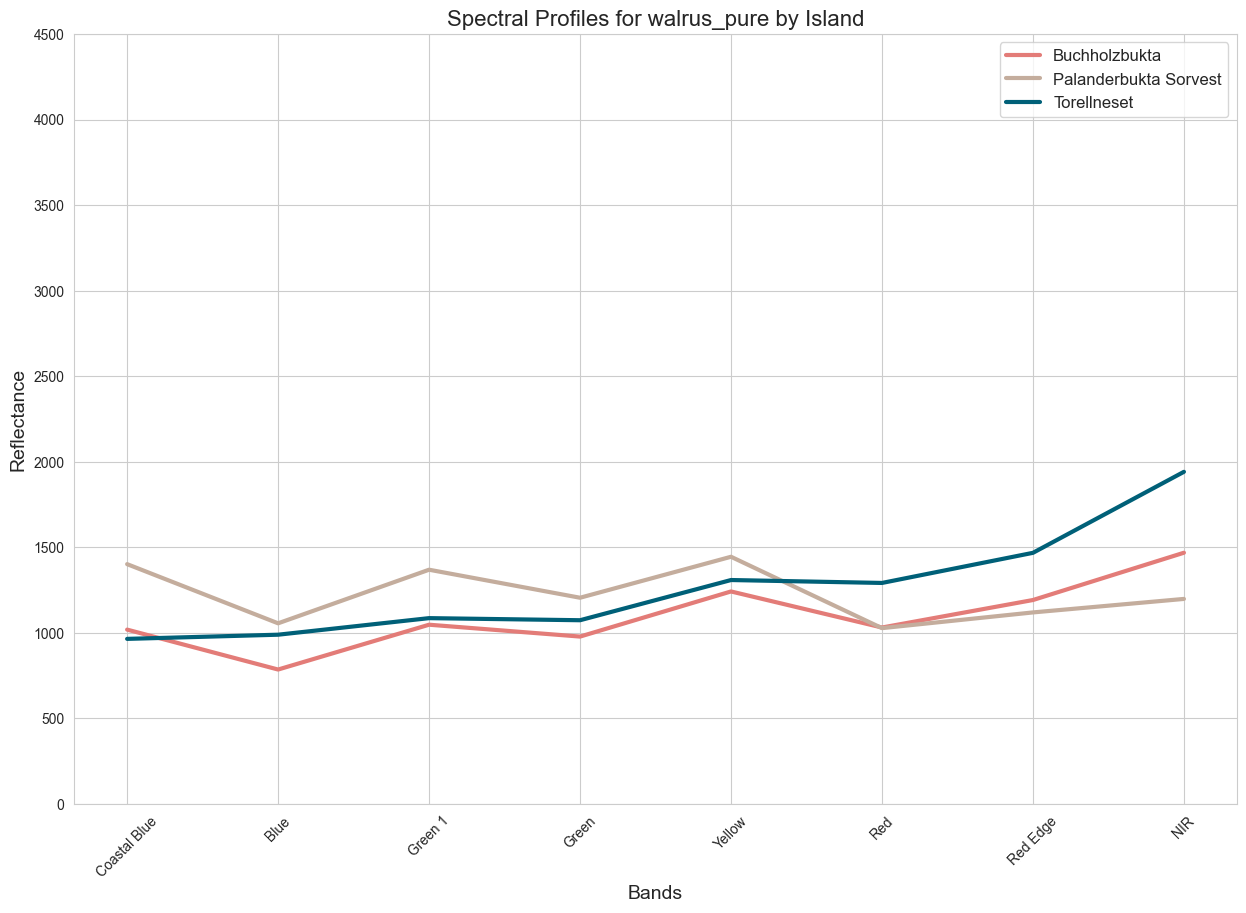

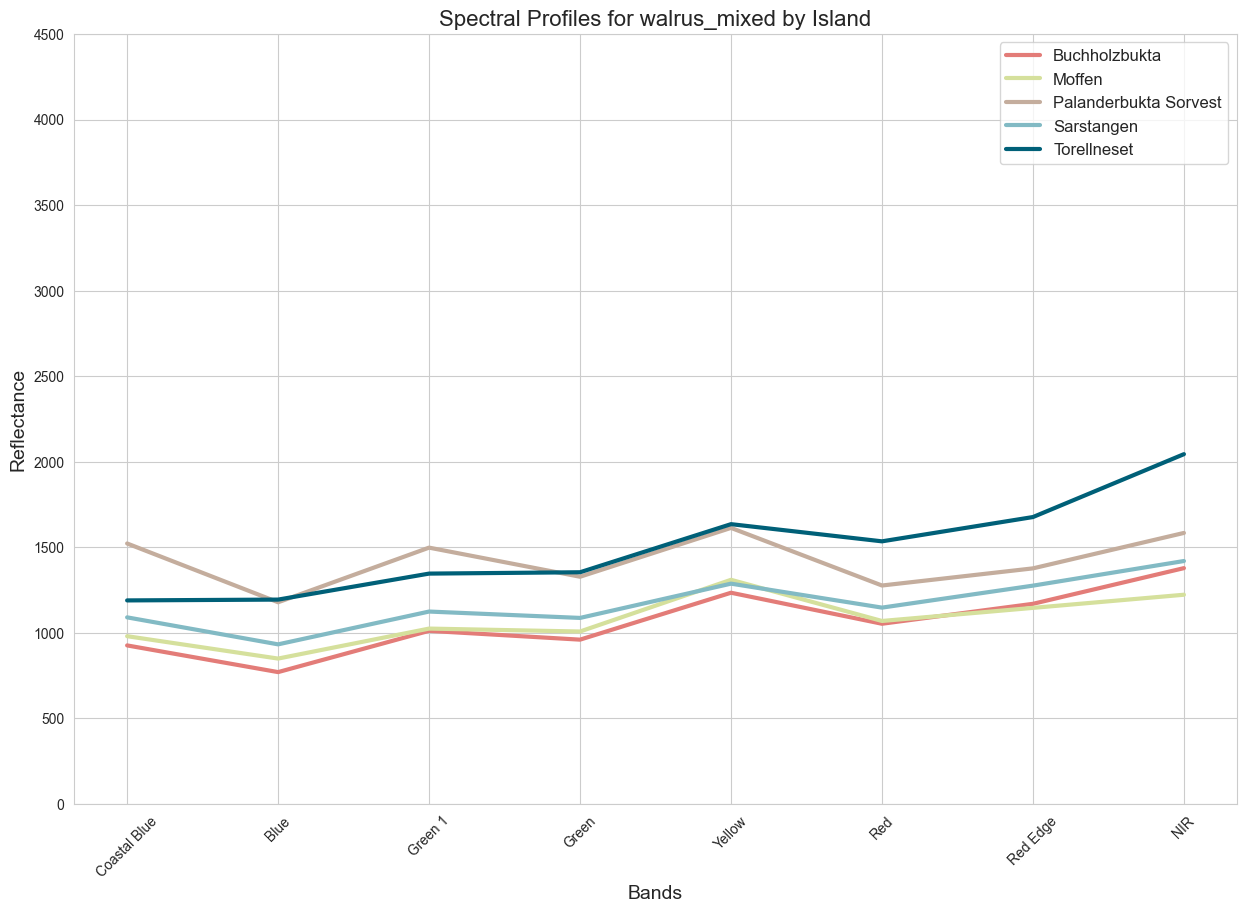

In [66]:
# Extract the islands from the dataset
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

bands = np.arange(8)  # Assuming there are 8 bands

# Define color palette similar to the provided image
island_colors = {
    'buch': '#E37C78',  # Buchholzbukta
    'moff': '#D5E09C',  # Moffen
    'pal': '#C4AD9D',  # Palanderbukta Sorvest
    'sars': '#82BAC4',  # Sarstangen
    'tor': '#006078'   # Torellneset
}

# Define a mapping from island identifiers to descriptive names
island_names = {
    'buch': 'Buchholzbukta',
    'moff': 'Moffen',
    'pal': 'Palanderbukta Sorvest',
    'sars': 'Sarstangen',
    'tor': 'Torellneset'
}

# Normalize the number of islands and colors
if len(islands) > len(island_colors):
    raise ValueError("Not enough colors for the number of islands.")

for class_label in unique_labels:
    plt.figure(figsize=(15, 10))
    for i, island in enumerate(islands):
        island_class_data = dataset[(dataset['labels'] == class_label) & (dataset['image_name'].str.contains(island))].iloc[:, :8].values
        if island_class_data.shape[0] > 0:
            mean = island_class_data.mean(axis=0)
            plt.plot(bands, mean, label=island_names[island], color=list(island_colors.values())[i], linewidth=3)

    # Set the same scale for all plots
    plt.ylim(0, 4500)

    # Set custom tick labels with descriptive names
    band_names = list(band_wavelengths.keys())
    plt.xticks(ticks=bands, labels=band_names, rotation=45)

    plt.xlabel('Bands', fontsize=14)
    plt.ylabel('Reflectance', fontsize=14)
    plt.title(f'Spectral Profiles for {class_label} by Island', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()

In [68]:
# Desired number of pixels for undersampling
desired_counts = {
    'walrus_mixed': 222,
    'walrus_pure': 222,
    'ocean': 222,
    'rock': 222,
    'freshwater': 222,
    'ice': 222
}

# Step 5: Undersample larger classes
undersampled_data = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label]
    if label in desired_counts:
        if len(class_data) > desired_counts[label]:
            undersampled_data.append(resample(class_data, replace=False, n_samples=desired_counts[label]))
        else:
            undersampled_data.append(class_data)
    else:
        undersampled_data.append(class_data)

undersampled_dataset = pd.concat(undersampled_data)

new_class_counts = undersampled_dataset['labels'].value_counts()
print("New number of pixels after undersampling:")
print(new_class_counts)

New number of pixels after undersampling:
labels
ocean           4000
ice             4000
rock            3000
freshwater      2000
walrus_mixed    1309
walrus_pure      222
Name: count, dtype: int64


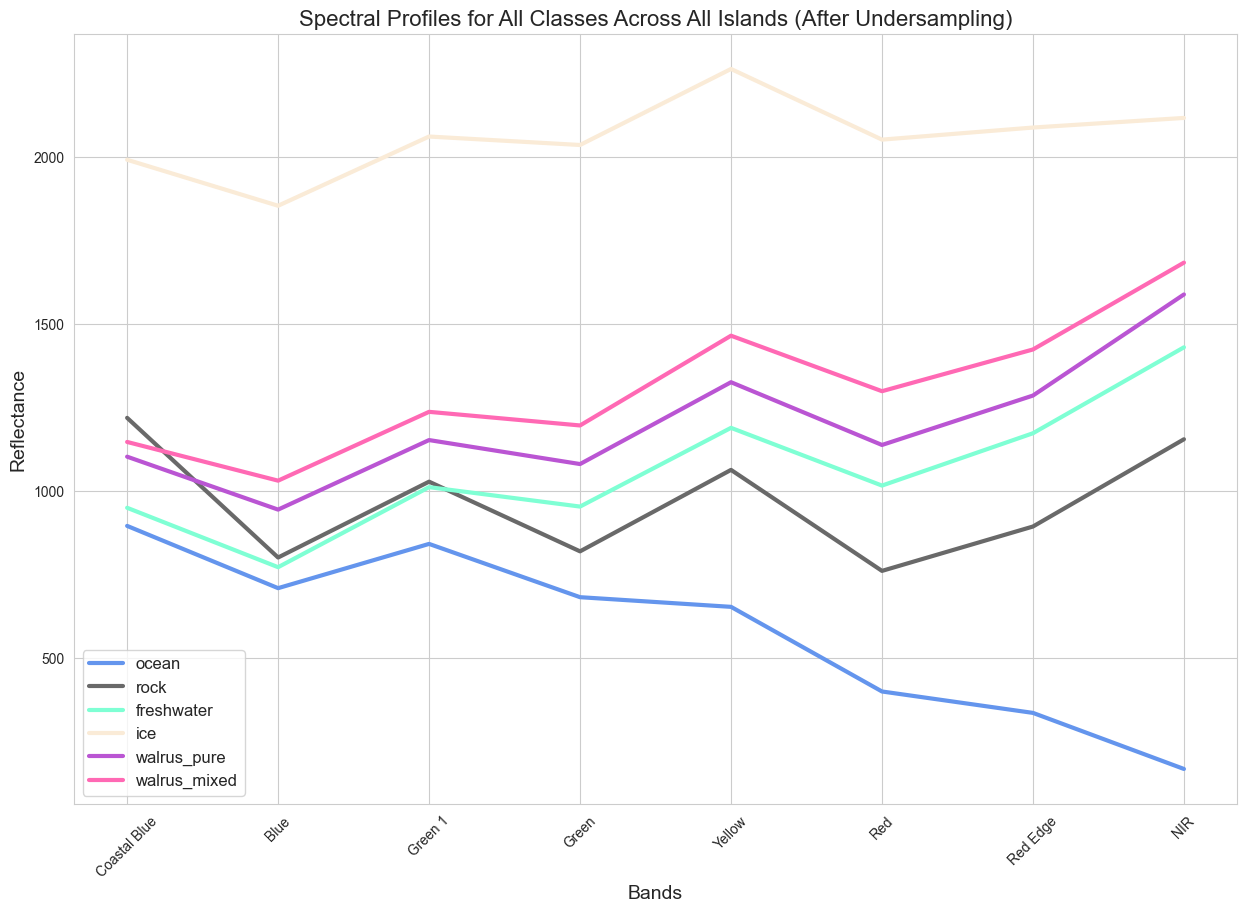

In [72]:
# Calculate mean profiles for undersampled data
undersampled_mean_profiles = []

for label in unique_labels:
    class_data = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].values
    undersampled_mean_profiles.append(class_data.mean(axis=0))

undersampled_mean_profiles = np.array(undersampled_mean_profiles)

# Plot the spectral profiles with thicker lines
plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = undersampled_mean_profiles[class_index]
    plt.plot(bands, mean, label=class_label, color=label_colors.get(class_label, 'black'), linewidth=3)  # Thicker line

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands (After Undersampling)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

New number of pixels after undersampling:
labels
ocean           4000
ice             4000
rock            3000
freshwater      2000
walrus_mixed    1309
walrus_pure      222
Name: count, dtype: int64


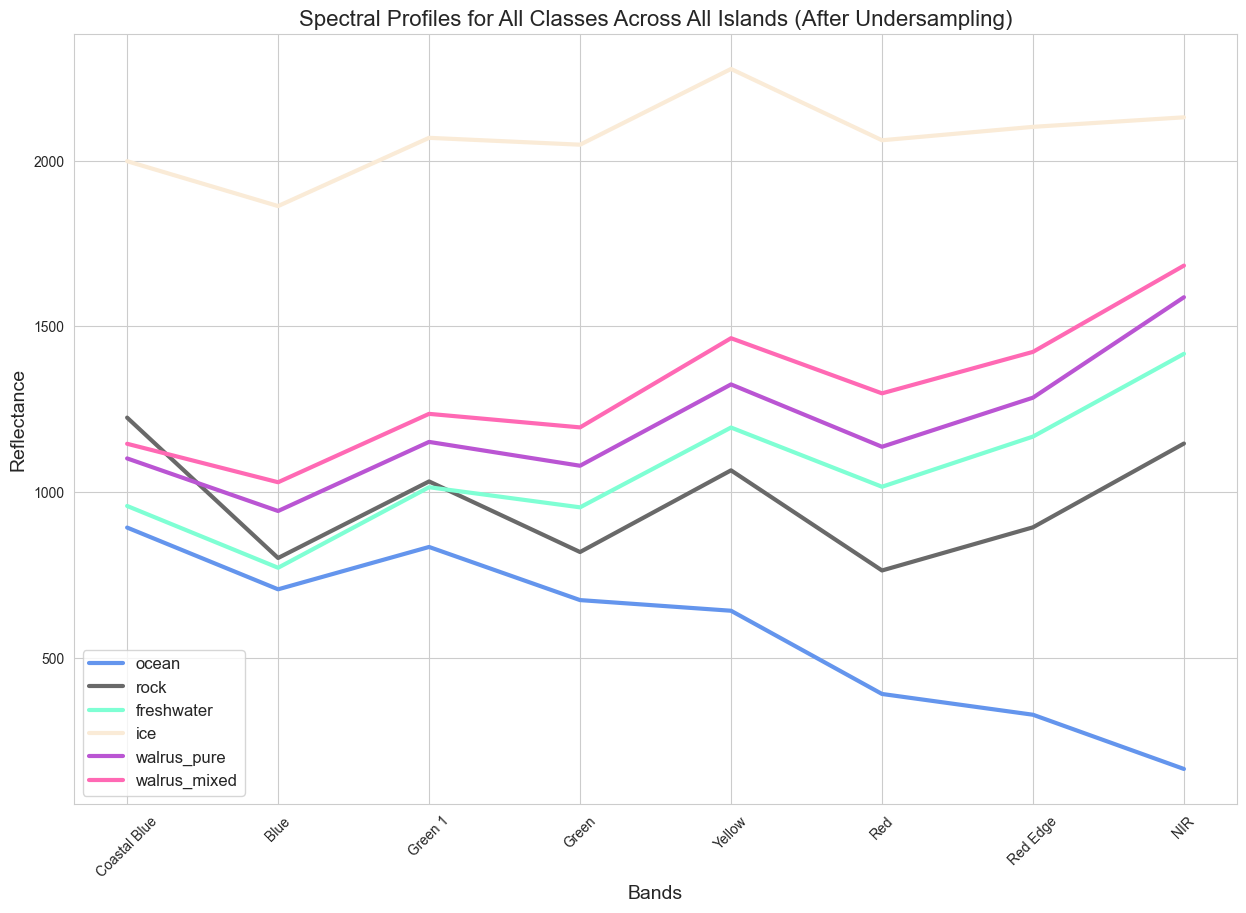

In [73]:
# Desired number of pixels for undersampling
desired_counts = {
    'walrus_mixed': 1309,
    'walrus_pure': 222,
    'ocean': 4000,
    'rock': 3000,
    'freshwater': 2000,
    'ice': 4000
}

# Assuming 'dataset' and 'unique_labels' are already defined
# Step 5: Undersample larger classes
undersampled_data = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label]
    if label in desired_counts:
        if len(class_data) > desired_counts[label]:
            undersampled_data.append(resample(class_data, replace=False, n_samples=desired_counts[label]))
        else:
            undersampled_data.append(class_data)
    else:
        undersampled_data.append(class_data)

# Concatenate all the undersampled data
undersampled_dataset = pd.concat(undersampled_data)

# Print new class counts to confirm undersampling
new_class_counts = undersampled_dataset['labels'].value_counts()
print("New number of pixels after undersampling:")
print(new_class_counts)

# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  # Coastal Blue
    'Blue': (465, 515),  # Blue
    'Green 1': (513, 549),  # Green 1
    'Green': (547, 583),  # Green
    'Yellow': (600, 620),  # Yellow
    'Red': (630, 680),  # Red
    'Red Edge': (697, 713),  # Red Edge
    'NIR': (845, 885)   # NIR
}

# Calculate mean profiles for undersampled data
undersampled_mean_profiles = []

for label in unique_labels:
    class_data = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].values
    undersampled_mean_profiles.append(class_data.mean(axis=0))

undersampled_mean_profiles = np.array(undersampled_mean_profiles)

# Plot the spectral profiles with thicker lines
plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = undersampled_mean_profiles[class_index]
    plt.plot(bands, mean, label=class_label, color=label_colors.get(class_label, 'black'), linewidth=3)  # Thicker line

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands (After Undersampling)', fontsize=16)
plt.legend(fontsize=12)
plt.show()

New number of pixels after undersampling:
labels
ocean           4000
ice             4000
rock            3000
freshwater      2000
walrus_mixed    1309
walrus_pure      222
Name: count, dtype: int64


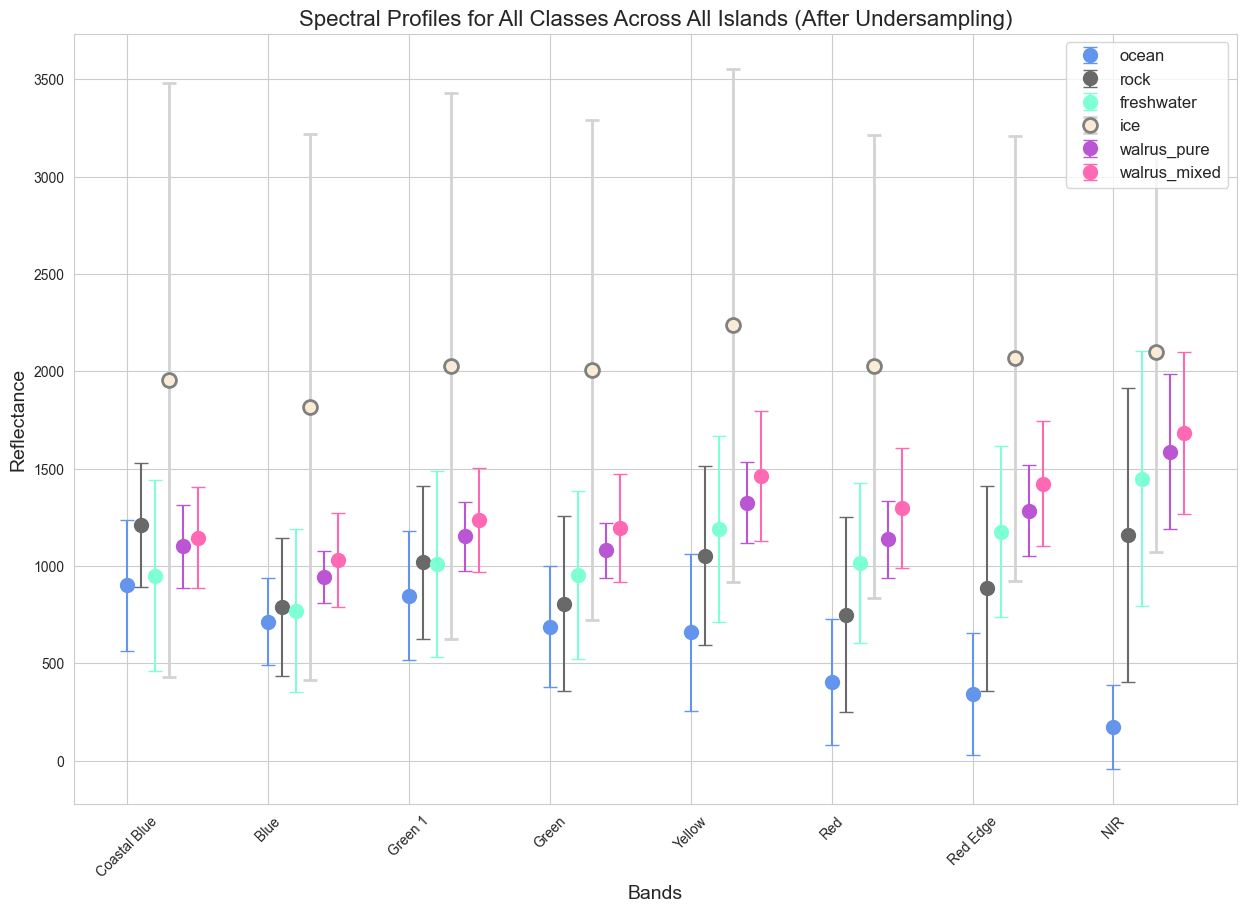

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Desired number of pixels for undersampling
desired_counts = {
    'walrus_mixed': 1309,
    'walrus_pure': 222,
    'ocean': 4000,
    'rock': 3000,
    'freshwater': 2000,
    'ice': 4000
}

# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  # Coastal Blue
    'Blue': (465, 515),  # Blue
    'Green 1': (513, 549),  # Green 1
    'Green': (547, 583),  # Green
    'Yellow': (600, 620),  # Yellow
    'Red': (630, 680),  # Red
    'Red Edge': (697, 713),  # Red Edge
    'NIR': (845, 885)   # NIR
}

# Assuming 'dataset' and 'unique_labels' are already defined
# Step 5: Undersample larger classes
undersampled_data = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label]
    if label in desired_counts:
        if len(class_data) > desired_counts[label]:
            undersampled_data.append(resample(class_data, replace=False, n_samples=desired_counts[label]))
        else:
            undersampled_data.append(class_data)
    else:
        undersampled_data.append(class_data)

undersampled_dataset = pd.concat(undersampled_data)

new_class_counts = undersampled_dataset['labels'].value_counts()
print("New number of pixels after undersampling:")
print(new_class_counts)

# Calculate mean and std profiles for undersampled data
unique_labels = undersampled_dataset['labels'].unique()
bands = np.arange(8)  # Assuming there are 8 bands as per the original data structure
mean_profiles = []
std_profiles = []

for label in unique_labels:
    class_data = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

# Staggering factor
staggering_factor = 0.1

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    offset = class_index * staggering_factor
    if class_label == 'ice':
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color='antiquewhite', fmt='o', capsize=5, markersize=10, ecolor='lightgrey', elinewidth=2, markeredgewidth=2, markeredgecolor='grey')
    else:
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color=label_colors.get(class_label, 'black'), fmt='o', capsize=5, markersize=10)

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands (After Undersampling)', fontsize=16)
plt.legend(fontsize=12)
plt.show()


In [16]:
# Dictionary to store the desired number of pixels for each class by island
island_desired_counts = {
    'buch': {'walrus_mixed': 162, 'walrus_pure': 66, 'ocean': 300, 'rock': 300, 'freshwater': 300, 'ice': 300},
    'moff': {'walrus_mixed': 44, 'walrus_pure': 0, 'ocean': 400, 'rock': 0, 'freshwater': 244, 'ice': 400},
    'pal': {'walrus_mixed': 188, 'walrus_pure': 61, 'ocean': 300, 'rock': 300, 'freshwater': 0, 'ice': 300},
    'sars': {'walrus_mixed': 57, 'walrus_pure': None, 'ocean': 200, 'rock': None, 'freshwater': None, 'ice': 200},
    'tor': {'walrus_mixed': 360, 'walrus_pure': 71, 'ocean': 500, 'rock': 500, 'freshwater': 500, 'ice': 500}
}

In [25]:
print("Sars images:")
print([path for path in image_paths if 'sars' in path.lower()])
print("\nSars shapefiles:")
print([path for path in shapefile_paths if 'sars' in path.lower()])
print("\nSars new walrus shapefiles:")
print([path for path in new_walrus_paths if 'sars' in path.lower()])

Sars images:
['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\sars_20230714_image.tif', 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\sars_20230803_image.tif']

Sars shapefiles:
['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train\\sars_20230714_train.shp', 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train\\sars_20230803_train.shp']

Sars new walrus shapefiles:
['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles\\sars_20230714_walrus.shp', 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles\\sars_20230803_walrus.shp']


In [32]:
sars_shapefiles = [path for path in shapefile_paths if 'sars' in path.lower()]
for shapefile in sars_shapefiles:
    print(f"Checking shapefile: {shapefile}")
    gdf = gpd.read_file(shapefile)
    print("Labels in this shapefile:")
    print(gdf['label'].value_counts())
    print()

Checking shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\sars_20230714_train.shp
Labels in this shapefile:
label
ocean           5
ice             3
walrus_mixed    2
Name: count, dtype: int64

Checking shapefile: C:\Users\Student\Documents\101_walrus_data\train\clipped_train\sars_20230803_train.shp
Labels in this shapefile:
label
ice             3
ocean           3
walrus_mixed    1
Name: count, dtype: int64


In [28]:
def debug_extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    print(f"Labels in shapefile {shapefile_path}:")
    print(gdf['label'].value_counts())

    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        print(f"Extracting {len(feature_pixels.T)} pixels for label {label}")

        for pixel in feature_pixels.T:
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Use this function for Sars images
sars_pairs = {k: v for k, v in file_pairs.items() if 'sars' in k.lower()}
for image_path, shapefile_path in sars_pairs.items():
    print(f"Processing Sars pair:")
    print(f"Image: {image_path}")
    print(f"Shapefile: {shapefile_path}")
    features, labels, _ = debug_extract_features_labels(image_path, shapefile_path)
    print("Extracted labels:")
    unique, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique, counts)))
    print()

Processing Sars pair:
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230714_image.tif
Shapefile: C:\Users\Student\Documents\101_walrus_data\train\walrus_shapefiles\sars_20230714_walrus.shp
Labels in shapefile C:\Users\Student\Documents\101_walrus_data\train\walrus_shapefiles\sars_20230714_walrus.shp:
label
walrus_mixed    2
Name: count, dtype: int64
Extracting 7 pixels for label walrus_mixed
Extracting 10 pixels for label walrus_mixed
Extracted labels:
{'walrus_mixed': 17}

Processing Sars pair:
Image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230803_image.tif
Shapefile: C:\Users\Student\Documents\101_walrus_data\train\walrus_shapefiles\sars_20230803_walrus.shp
Labels in shapefile C:\Users\Student\Documents\101_walrus_data\train\walrus_shapefiles\sars_20230803_walrus.shp:
label
walrus_mixed    1
Name: count, dtype: int64
Extracting 40 pixels for label walrus_mixed
Extracted labels:
{'walrus_mixed': 40}


In [29]:
def debug_get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        if 'sars' in image_path.lower():
            print(f"Processing Sars image: {image_path}")
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

        if 'sars' in image_path.lower():
            print("Labels extracted:")
            unique, counts = np.unique(img_labels, return_counts=True)
            print(dict(zip(unique, counts)))

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = debug_get_dataset(file_pairs)

# Check final Sars data
sars_mask = np.array(['sars' in img.lower() for img in image_name])
sars_labels = labels[sars_mask]
print("Final Sars labels:")
unique, counts = np.unique(sars_labels, return_counts=True)
print(dict(zip(unique, counts)))

Processing Sars image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230714_image.tif
Labels extracted:
{'walrus_mixed': 17}
Processing Sars image: C:\Users\Student\Documents\101_walrus_data\train\clipped_images\sars_20230803_image.tif
Labels extracted:
{'walrus_mixed': 40}
Final Sars labels:
{'walrus_mixed': 57}


In [26]:
sars_data = dataset[dataset['image_name'].str.contains('sars')]
print("Sars data before undersampling:")
print(sars_data['labels'].value_counts())

Sars data before undersampling:
labels
walrus_mixed    57
Name: count, dtype: int64


In [33]:
# Step 6: Undersample by island and replot island-by-island comparisons
island_undersampled_data = []

# Dictionary to store class counts by island
island_class_counts = {}

for island in islands:
    island_data = dataset[dataset['image_name'].str.contains(island)]
    island_undersampled_classes = []

    if island in island_desired_counts:
        for label, desired_count in island_desired_counts[island].items():
            class_data = island_data[island_data['labels'] == label]
            if len(class_data) > 0:
                # Determine the number of samples to use
                if desired_count is None:
                    n_samples = len(class_data)  # Use all available pixels
                else:
                    n_samples = min(desired_count, len(class_data))
                
                island_undersampled_classes.append(resample(class_data, replace=False, n_samples=n_samples))
            else:
                continue

    undersampled_island_df = pd.concat(island_undersampled_classes) if island_undersampled_classes else pd.DataFrame(columns=dataset.columns)
    island_undersampled_data.append(undersampled_island_df)

    # Count the number of pixels for each class in this island
    island_class_counts[island] = undersampled_island_df['labels'].value_counts()

island_undersampled_dataset = pd.concat(island_undersampled_data)

# Print the pixel count by island after undersampling
print("Number of pixels after undersampling by island:")
for island, counts in island_class_counts.items():
    print(f"\nIsland: {island}")
    print(counts)

Number of pixels after undersampling by island:

Island: buch
labels
ocean           300
rock            300
freshwater      300
ice             300
walrus_pure      66
walrus_mixed     43
Name: count, dtype: int64

Island: moff
labels
ocean         400
ice           400
freshwater    244
Name: count, dtype: int64

Island: pal
labels
ocean    300
rock     300
ice      300
Name: count, dtype: int64

Island: sars
labels
ocean           143231
ice               5789
walrus_mixed        57
Name: count, dtype: int64

Island: tor
labels
ocean           500
rock            500
freshwater      500
ice             500
walrus_mixed    196
walrus_pure      42
Name: count, dtype: int64


In [ ]:
for class_label in unique_labels:
    plt.figure(figsize=(15, 10))
    for island in islands:
        island_class_data = island_undersampled_dataset[(island_undersampled_dataset['labels'] == class_label) & (island_undersampled_dataset['image_name'].str.contains(island))].iloc[:, :8].values
        if island_class_data.shape[0] > 0:
            mean = island_class_data.mean(axis=0)
            std = island_class_data.std(axis=0)
            plt.plot(bands, mean, label=island)
            plt.fill_between(bands, mean - std, mean + std, alpha=0.3)

    plt.xlabel('Bands', fontsize=14)
    plt.ylabel('Reflectance', fontsize=14)
    plt.title(f'Spectral Profiles for {class_label} by Island After Undersampling', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()